# XPCS&XSVS Pipeline for Single-(Gi)-SAXS Run
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

### DEV
* V8: Update visbility error bar calculation using pi = his/N +/- sqrt(his_i)/N
*     Update normlization in g2 calculation uing 2D-savitzky golay (SG ) smooth

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [3]:
from pyCHX.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk
from pyCHX.chx_xpcs_xsvs_jupyter_V1 import *
import itertools

In [4]:
%matplotlib notebook
#%matplotlib inline

### please run the next cell three times

In [5]:
Javascript( '''
        var nb = IPython.notebook;
        var kernel = IPython.notebook.kernel;
        var command = "NFP = '" + nb.base_url + nb.notebook_path + "'";        
        kernel.execute(command);
        ''' )

<IPython.core.display.Javascript object>

In [6]:
#print( 'The current running pipeline is: %s' %NFP)

In [7]:
#%reset -f -s dhist in out array

## Control Runs Here

In [8]:
scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'ang_saxs' 
#scat_geometry = 'gi_waxs' 
#scat_geometry = 'gi_saxs'

analysis_type_auto = True #if True, will take "analysis type" option from data acquisition func series
qphi_analysis = False  #if True, will do q-phi (anisotropic analysis for transmission saxs)

isotropic_Q_mask = 'normal' #'wide' # 'normal' # 'wide'  ## select wich Q-mask to use for rings: 'normal' or 'wide'
phi_Q_mask = 'phi_4x_20deg'   ## select wich Q-mask to use for phi analysis
q_mask_name = ''

force_compress = False #True   #force to compress data 
bin_frame = False   #generally make bin_frame as False
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall =  False   #run waterfall analysis
run_profile_plot = False  #run prolfile plot for gi-saxs
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_get_mass_center = False  # Analysis for mass center of reflective beam center
run_invariant_analysis = False
run_one_time =  True  #run  one-time
cal_g2_error = False#True  #calculate g2 signal to noise
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time =   True    #run  two-time
run_four_time = False #True #True #False   #run  four-time
run_xsvs=  False #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 1 #the intested single qth             
use_sqnorm = True    #if True, use sq to normalize intensity
use_SG = True # False        #if True, use the Sawitzky-Golay filter for <I(pix)>
use_imgsum_norm= True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_%s'%get_today_date()     #for pdf report name
run_dose = False  #run dose_depend analysis

if scat_geometry == 'gi_saxs':run_xsvs= False;use_sqnorm=False
if scat_geometry == 'gi_waxs':use_sqnorm = False
if scat_geometry != 'saxs':qphi_analysis = False;scat_geometry_ = scat_geometry  
else:scat_geometry_ = ['','ang_'][qphi_analysis]+ scat_geometry   
if scat_geometry != 'gi_saxs':run_profile_plot = False

In [9]:
scat_geometry

'saxs'

In [10]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None; lag_steps = None 

## Make a directory for saving results

In [11]:
CYCLE= '2018_2'  #change clycle here
path = '/XF11ID/analysis/%s/masks/'%CYCLE
username =  getpass.getuser()
#username = 'rheadric'
data_dir0  = create_user_folder(CYCLE, username)
print( data_dir0 )

Results from this analysis will be stashed in the directory /XF11ID/analysis/2018_2/yuzhang/Results/
/XF11ID/analysis/2018_2/yuzhang/Results/


## Load Metadata & Image Data



### Change this line to give a uid

In [12]:
uid = 'cc08d7' ##Wed Jul 25 16:13:04 2018 #22540: 0.000112s x 10k T=1 AFRL membrane ink 17wt% solids--  cc08d718-0031-4057-99b0-283f716d6490 



In [13]:
uid = uid[:8]
print('The current uid for analysis is: %s...'%uid)

The current uid for analysis is: cc08d7...


In [14]:
#get_last_uids( -3)

In [15]:
sud = get_sid_filenames(db[uid])
for pa in sud[2]:
    if 'master.h5' in pa:
        data_fullpath = pa
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], data_fullpath ))

#start_time, stop_time = '2017-2-24  12:23:00', '2017-2-24  13:42:00' 
#sids, uids, fuids  = find_uids(start_time, stop_time)

filepath : /nsls2/xf11id1/data/2018/07/25/272622f3-bd01-4496-b39c
got images_per_file
scan_id, full-uid, data path are:  22540--cc08d718-0031-4057-99b0-283f716d6490--/nsls2/xf11id1/data/2018/07/25/272622f3-bd01-4496-b39c_25_master.h5


In [16]:
data_dir = os.path.join(data_dir0, '%s/'%(sud[1]))
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/


# Don't Change the lines below here

* get metadata

In [17]:
md = get_meta_data( uid )
md_blue = md.copy()
#md_blue

More than one device. This would have unintented consequences.Currently, only use the first device.


In [18]:
#md_blue['detectors'][0]
#if md_blue['OAV_mode'] != 'none':
#    cx , cy = md_blue[md_blue['detectors'][0]+'_beam_center_x'], md_blue[md_blue['detectors'][0]+'_beam_center_x']
#else: 
#    cx , cy = md_blue['beam_center_x'], md_blue['beam_center_y']
#print(cx,cy)

In [19]:
detectors = sorted(get_detectors(db[uid]))
print('The detectors are:%s'%detectors)
if len(detectors) >1:
    md['detector'] = detectors[1]
    print( md['detector'])


The detectors are:['eiger500K_single_image']


In [20]:
if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    reverse= True
    rot90= False
elif md['detector'] =='eiger500K_single_image':    
    reverse= True
    rot90=True
elif md['detector'] =='eiger1m_single_image':    
    reverse= True
    rot90=False
print('Image reverse: %s\nImage rotate 90: %s'%(reverse, rot90))    

Image reverse: True
Image rotate 90: True


In [21]:
try:
    cx , cy = md_blue['beam_center_x'], md_blue['beam_center_y']
    print(cx,cy)
except:
    print('Will find cx,cy later.')


356.0 98.0


### Load ROI defined by "XPCS_Setup" Pipeline

#### Define data analysis type

In [22]:
if analysis_type_auto:#if True, will take "analysis type" option from data acquisition func series
    try:
        qphi_analysis_ = md['analysis'] #if True, will do q-phi (anisotropic analysis for transmission saxs)
        print(md['analysis'])
        if qphi_analysis_ == 'iso':
            qphi_analysis = False
        elif qphi_analysis_ == '':
            qphi_analysis = False
        else:
            qphi_analysis = True
    except:
        print('There is no analysis in metadata.')
        
print('Will %s qphis analysis.'%['NOT DO','DO'][qphi_analysis]) 

if scat_geometry != 'saxs':qphi_analysis = False;scat_geometry_ = scat_geometry  
else:scat_geometry_ = ['','ang_'][qphi_analysis]+ scat_geometry   
if scat_geometry != 'gi_saxs':run_profile_plot = False 
print(scat_geometry_)    


Will NOT DO qphis analysis.
saxs


In [23]:
scat_geometry

'saxs'

#### Load ROI mask depending on data analysis type

In [24]:
##For SAXS 
if scat_geometry =='saxs':
    if qphi_analysis ==  False:
        if isotropic_Q_mask == 'normal':
            #print('Here')
            q_mask_name='rings'
            if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M 
                 fp = '/XF11ID/analysis/2018_2/masks/roi_mask_July23_4M_norm.pkl' 
            elif md['detector'] =='eiger500K_single_image': #for 500K   
                fp = '/XF11ID/analysis/2018_2/masks/roi_mask_July23_500K_norm.pkl'
                
                
        elif isotropic_Q_mask == 'wide':
            q_mask_name='wide_rings'
            if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M   
                fp = '/XF11ID/analysis/2018_2/masks/roi_mask_July23_4M_wide.pkl'
            elif md['detector'] =='eiger500K_single_image': #for 500K   
                fp =  '/XF11ID/analysis/2018_2/masks/roi_mask_July23_500K_wide.pkl'

    elif qphi_analysis:
        if phi_Q_mask =='phi_4x_20deg':
            q_mask_name='phi_4x_20deg'
            if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M                 
                fp = '/XF11ID/analysis/2018_2/masks/roi_mask_July23_4M_phi_4x_20deg.pkl'
                
            elif md['detector'] =='eiger500K_single_image': #for 500K   
                fp = '/XF11ID/analysis/2018_2/masks/roi_mask_July23_500K_phi_4x_20deg.pkl'
            
    #fp = 'XXXXXXX.pkl'            
    roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
    #print(fp)

## Gi_SAXS 
elif scat_geometry =='gi_saxs':    
    # dynamics mask
    fp = '/XF11ID/analysis/2018_2/masks/uid=460a2a3a_roi_mask.pkl'
#     fp = path + 'uid=d823d2_JGU_roi_mask.pkl'
    roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
    print('The dynamic mask is: %s.'%fp)
    # static mask
    fp = '/XF11ID/analysis/2018_2/masks/uid=460a2a3a_roi_masks.pkl'
    roi_masks,qval_dicts = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data    
    print('The static mask is: %s.'%fp)
    # q-map
    fp = '/XF11ID/analysis/2018_2/masks/uid=460a2a3a_qmap.pkl'
    #print(fp)
    qr_map, qz_map, ticks, Qrs, Qzs,  Qr, Qz, inc_x0,refl_x0, refl_y0 = cpk.load( open(fp, 'rb' )  )
    print('The qmap is: %s.'%fp)
    

## WAXS 
elif scat_geometry =='gi_waxs': 
    fp = '/XF11ID/analysis/2018_2/masks/uid=db5149a1_roi_mask.pkl'      
    roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data

print(roi_mask.shape)

(1030, 514)


In [25]:
#qval_dict

<IPython.core.display.Javascript object>


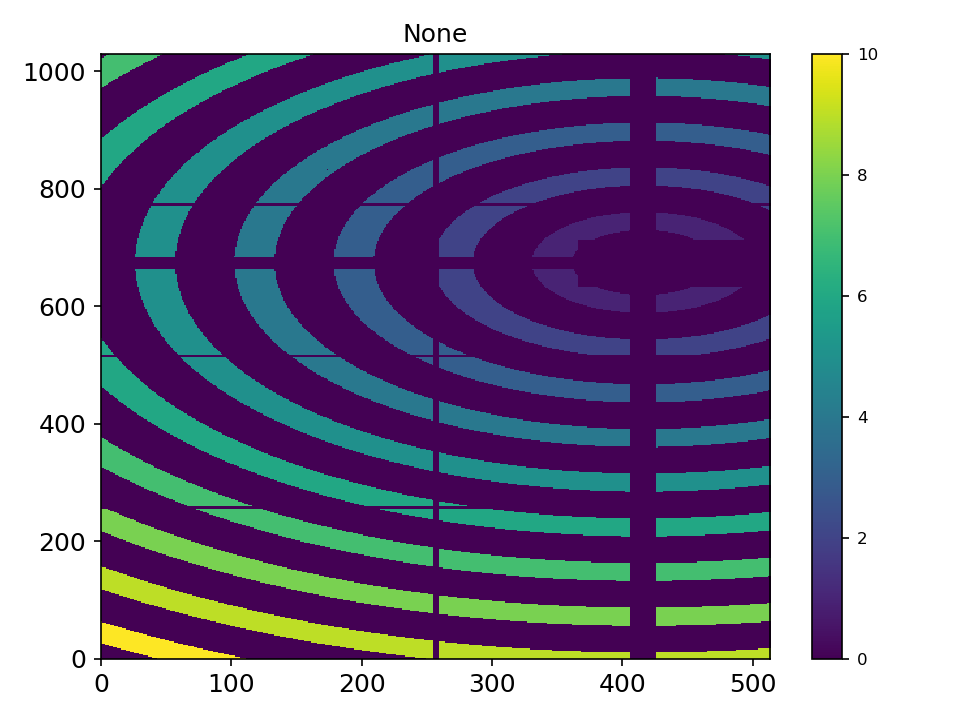

In [26]:
show_img(roi_mask)


In [27]:
#%run /home/yuzhang/pyCHX_link/pyCHX/chx_generic_functions.py

* get data

In [28]:
imgs = load_data( uid, md['detector'], reverse= reverse, rot90=rot90  )
md.update( imgs.md );Nimg = len(imgs);
#md['beam_center_x'], md['beam_center_y']  = cx, cy
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

#md['acquire period' ] = md['cam_acquire_period']
#md['exposure time'] =  md['cam_acquire_time']
mdn = md.copy()


The data are: Pipeline processed through proc_func. Original repr:
    Pipeline processed through proc_func. Original repr:
        EigerImages processed through proc_func. Original repr:
            <Frames>
            Length: 10000 frames
            Frame Shape: 514 x 1030
            Pixel Datatype: uint16


#### Load Chip mask depeding on detector

In [29]:
if md['detector'] =='eiger1m_single_image':
    Chip_Mask=np.load( '/XF11ID/analysis/2017_1/masks/Eiger1M_Chip_Mask.npy')
elif md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    Chip_Mask= np.array(np.load( '/XF11ID/analysis/2017_1/masks/Eiger4M_chip_mask.npy'), dtype=bool)
    BadPix =     np.load('/XF11ID/analysis/2018_1/BadPix_4M.npy'  )  
    Chip_Mask.ravel()[BadPix] = 0
elif md['detector'] =='eiger500K_single_image':
    #print('here')
    Chip_Mask=  np.load( '/XF11ID/analysis/2017_1/masks/Eiger500K_Chip_Mask.npy')  #to be defined the chip mask
    Chip_Mask = np.rot90(Chip_Mask)
    pixel_mask = np.rot90(  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool))   )
    
else:
    Chip_Mask = 1
#show_img(Chip_Mask)
print(Chip_Mask.shape, pixel_mask.shape)

(1030, 514) (1030, 514)


In [30]:
use_local_disk = True
import shutil,glob

In [31]:
# %run ~/pyCHX_link/pyCHX/chx_generic_functions.py

In [32]:
if len(detectors)==2:
    if '_image' in md['detector']:
        pref = md['detector'][:-5]
    else:
        pref=md['detector']
    for k in [ 'beam_center_x', 'beam_center_y','cam_acquire_time','cam_acquire_period','cam_num_images',
             'wavelength', 'det_distance', 'photon_energy']:
        md[k] =  md[ pref + '%s'%k]    
    
    if 'OAV_image' in detectors:
        try:
            tifs =  list( db[uid].data(  'OAV_image') )[0] 
            print(len(tifs))
            ## show all images
            fig, ax = show_tif_series( tifs, Nx = None, vmin=1.0, vmax=20, logs=False, cmap= cm.gray, figsize=[4,6] )
            ##show one image
            #show_img(tifs[0],cmap= cm.gray,)
        except:
            pass
        

In [33]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distance', 'beam_center_x', 'beam_center_y', ] )

suid--> cc08d7
number of images--> 10000
uid--> cc08d718-0031-4057-99b0-283f716d6490
scan_id--> 22540
start_time--> 2018-07-25 16:13:04
stop_time--> 2018-07-25 16:15:30
sample--> AFRL membrane ink 17wt% solids
Measurement--> 0.000112s x 10k T=1 AFRL membrane ink 17wt% solids
acquire period--> 0.00012
exposure time--> 0.00012
det_distance--> 10.11429977417
beam_center_x--> 356.0
beam_center_y--> 98.0


## Overwrite Some Metadata if Wrong Input

### Define incident beam center (also define reflection beam center for gisaxs)

In [34]:
if scat_geometry =='gi_saxs':
    inc_x0 =  md['beam_center_x'] 
    inc_y0 =  imgs[0].shape[0] - md['beam_center_y']     
    refl_x0 =     md['beam_center_x']  
    refl_y0 =     1000     #imgs[0].shape[0] -  1758  
    
    print( "inc_x0, inc_y0, ref_x0,ref_y0 are: %s %s %s %s."%(inc_x0, inc_y0, refl_x0, refl_y0) )
else:
    if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image' or md['detector']=='eiger1m_single_image':    
        inc_x0 =  imgs[0].shape[0] - md['beam_center_y']   
        inc_y0=   md['beam_center_x']
    elif md['detector'] =='eiger500K_single_image':    
        inc_y0 =  imgs[0].shape[1] - md['beam_center_y']   
        inc_x0 =   imgs[0].shape[0] - md['beam_center_x']
    
    print(inc_x0, inc_y0)
    ###for this particular uid, manually give x0/y0
    #inc_x0 = 1041
    #inc_y0 = 1085

674.0 416.0


In [37]:
dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )
if scat_geometry =='gi_saxs':center=center[::-1]
setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)
print_dict( setup_pargs )


Beam_center_x has been changed to 416.0. (no change in raw metadata): 
Beam_center_y has been changed to 674.0.  (no change in raw metadata): 
uid--> uid=cc08d7
dpix--> 0.07500000356230885
Ldet--> 10114.29977417
lambda_--> 1.2852099
exposuretime--> 0.000114042785
timeperframe--> 0.00012
center--> [674, 416]
path--> /XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/


In [38]:
setup_pargs

{'uid': 'uid=cc08d7',
 'dpix': 0.07500000356230885,
 'Ldet': 10114.29977417,
 'lambda_': 1.2852099,
 'exposuretime': 0.000114042785,
 'timeperframe': 0.00012,
 'center': [674, 416],
 'path': '/XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change the lines below to give mask filename

In [39]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2018_2/masks/'    
    mask_name =  'July13_2018_4M.npy'
    
elif scat_geometry == 'saxs':
    mask_path = '/XF11ID/analysis/2018_2/masks/'
    if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
        mask_name = 'July23_2018_4M_SAXS.npy'     
    elif md['detector'] =='eiger500K_single_image':    
        mask_name = 'July23_2018_500K_SAXS.npy' 
        
elif scat_geometry == 'gi_waxs':    
    mask_path = '/XF11ID/analysis/2018_2/masks/'
    mask_name = 'July20_2018_1M_WAXS.npy'

<IPython.core.display.Javascript object>


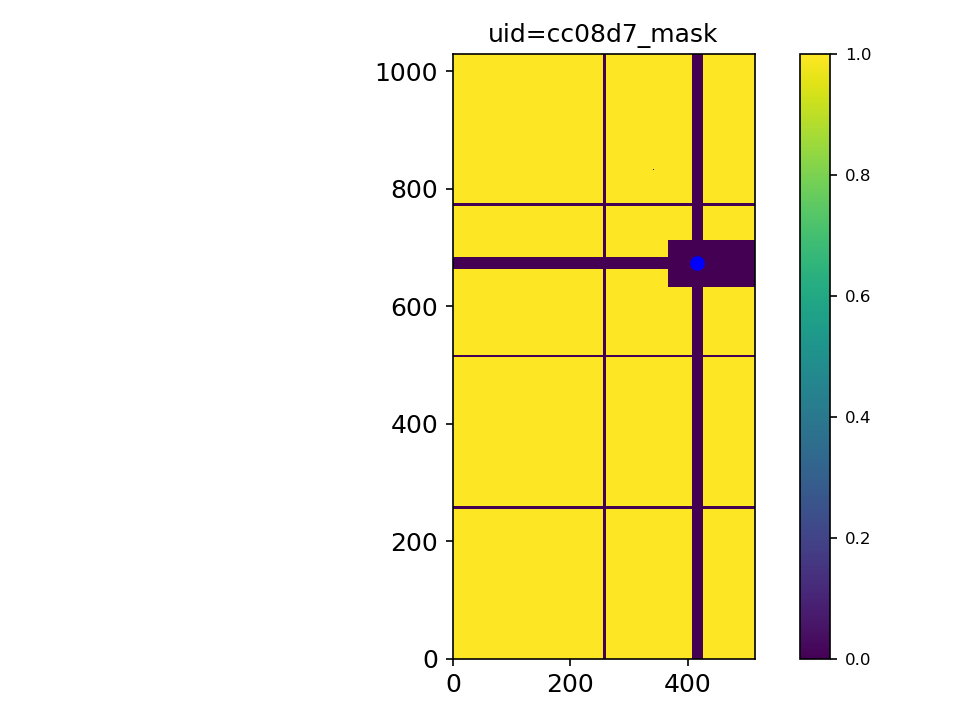

In [42]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse= reverse, rot90=rot90  ) 
mask =  mask * pixel_mask * Chip_Mask
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir, aspect=1, center=center[::-1])
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

# Check several frames average  intensity

In [43]:
img_choice_N = 3
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uidstr)
if avg_img.max() == 0:
    print('There are no photons recorded for this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')


In [44]:
#show_img( imgsa[1000],  vmin=.1, vmax= 1e1, logs=True, aspect=1,
#         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula )
print(center[::-1])

[416, 674]


<IPython.core.display.Javascript object>


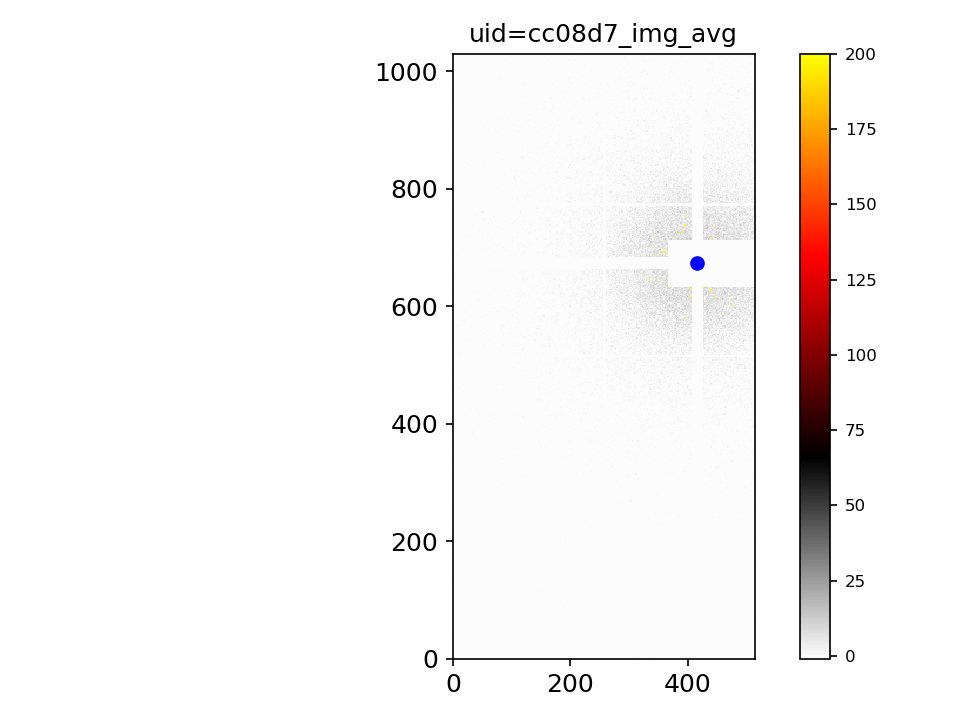

In [45]:
show_img( imgsa[ 5],  vmin = -1, vmax = 200, logs=False, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, path=data_dir, cmap=cmap_albula,center=center[::-1])
# select subregion, hard coded center beam location
#show_img( imgsa[180+40*3/0.05][110:110+840*2, 370:370+840*2],  vmin = 0.01, vmax = 20, logs=False, aspect=1, #save_format='tif',
#         image_name= uidstr + '_img_avg',  save=True, path=data_dir, cmap=cmap_albula,center=[845,839])

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [46]:
compress=True
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
#compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress
print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + 'Always ' + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.3430829964867213.
Will Always DO apply compress process.


In [47]:
if  md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    good_start =    5  #make the good_start at least 0
elif md['detector'] =='eiger500K_single_image': 
    good_start = 100  #5  #make the good_start at least 0
    
elif  md['detector'] =='eiger1m_single_image' or md['detector'] == 'image':    
    good_start =    5    

In [48]:
bin_frame =  False # True  #generally make bin_frame as False
if bin_frame:
    bin_frame_number=4
    acquisition_period = md['acquire period']
    timeperframe = acquisition_period * bin_frame_number
else:
    bin_frame_number =1

In [54]:
force_compress = False
#force_compress = True

Using already created compressed file with filename as :/nsls2/xf11id1/analysis/Compressed_Data/uid_cc08d718-0031-4057-99b0-283f716d6490.cmp.
The good_start frame number is: 100 
uid=cc08d7_fra_100_10000


<IPython.core.display.Javascript object>


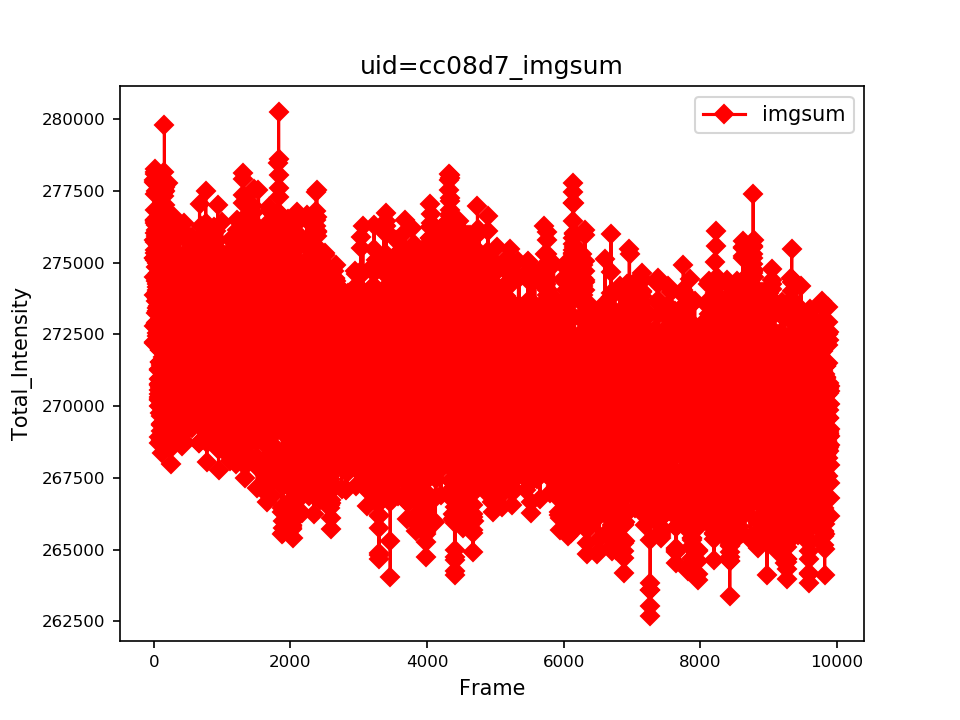

Total time: 0.365 sec


In [55]:
import time
t0= time.time()

if not use_local_disk:
    cmp_path = '/nsls2/xf11id1/analysis/Compressed_Data'
else:
    cmp_path = '/tmp_data/compressed'
    
    
cmp_path = '/nsls2/xf11id1/analysis/Compressed_Data'    
if bin_frame_number==1:   
    cmp_file = '/uid_%s.cmp'%md['uid']
else:
    cmp_file = '/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number)
    
filename = cmp_path + cmp_file  
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= para_compress,  bad_pixel_threshold = 1e14,
                                    reverse=reverse, rot90=rot90,
                        bins=bin_frame_number, num_sub= 100, num_max_para_process= 500, with_pickle=True,
                        direct_load_data =use_local_disk, data_path = data_fullpath, )                                  
                                                         
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)
FD = Multifile(filename, good_start, len(imgs)//bin_frame_number )
#FD = Multifile(filename, good_start, 100)
uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
print( uid_ )
plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
       title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
Nimg = Nimg/bin_frame_number
run_time(t0)

mask =  mask * pixel_mask * Chip_Mask
mask_copy = mask.copy()
mask_copy2 = mask.copy()



In [58]:
#%run ~/pyCHX_link/pyCHX/chx_generic_functions.py

In [59]:
try:
    if md['experiment']=='printing':
        #p = md['printing'] #if have this printing key, will do error function fitting to find t_print0
        find_tp0 = True
        t_print0 = ps(  y = imgsum[:400] ) * timeperframe
        print( 'The start time of print: %s.' %(t_print0  ) )
    else:
        find_tp0 = False
        print('md[experiment] is not "printing" -> not going to look for t_0')
        t_print0 = None
except:
    find_tp0 = False
    print('md[experiment] is not "printing" -> not going to look for t_0')
    t_print0 = None


md[experiment] is not "printing" -> not going to look for t_0


<IPython.core.display.Javascript object>


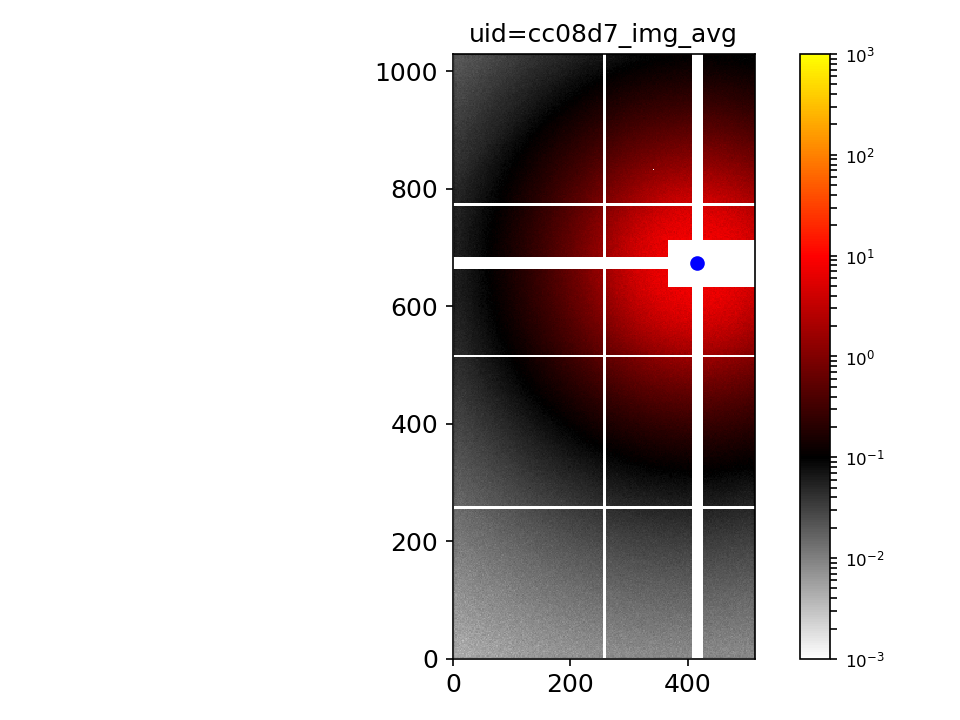

In [60]:
show_img( avg_img,  vmin=1e-3, vmax= 1e3, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, 
         path=data_dir, center=center[::-1], cmap = cmap_albula )

## Get bad frame list by a polynominal fit

In [61]:
good_end= None # 2000  
if good_end is not None:
    FD = Multifile(filename, good_start, min( len(imgs)//bin_frame_number, good_end) )
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )
    

In [62]:
re_define_good_start =False
if re_define_good_start:
    good_start = 180
    #good_end = 19700
    good_end = len(imgs)
    FD = Multifile(filename, good_start, good_end) 
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( FD.beg, FD.end)

/nsls2/xf11id1/analysis/Analysis_Pipelines/Develop/pyCHX/pyCHX/chx_generic_functions.py:1598: RankWarning: Polyfit may be poorly conditioned
  pol = np.polyfit(x, y, order)


<IPython.core.display.Javascript object>


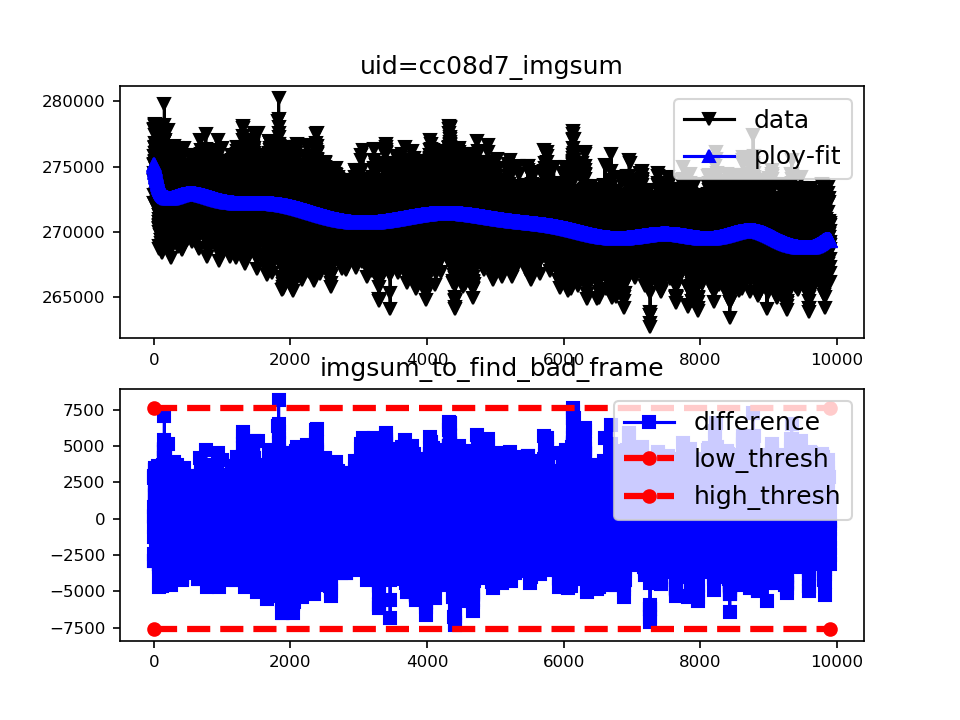

The bad frame list length is: 102


In [63]:
bad_frame_list =  get_bad_frame_list( imgsum, fit='both',  plot=True,polyfit_order = 30,                                      
                        scale= 3.5,  good_start = good_start, good_end=good_end, uid= uidstr, path=data_dir)

print( 'The bad frame list length is: %s'%len(bad_frame_list) )

### Creat new mask by masking the bad pixels and get new avg_img

In [64]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'],
           filename=uidstr + '_img_sum_t', path= data_dir  )


### Plot time~ total intensity of each frame

<IPython.core.display.Javascript object>


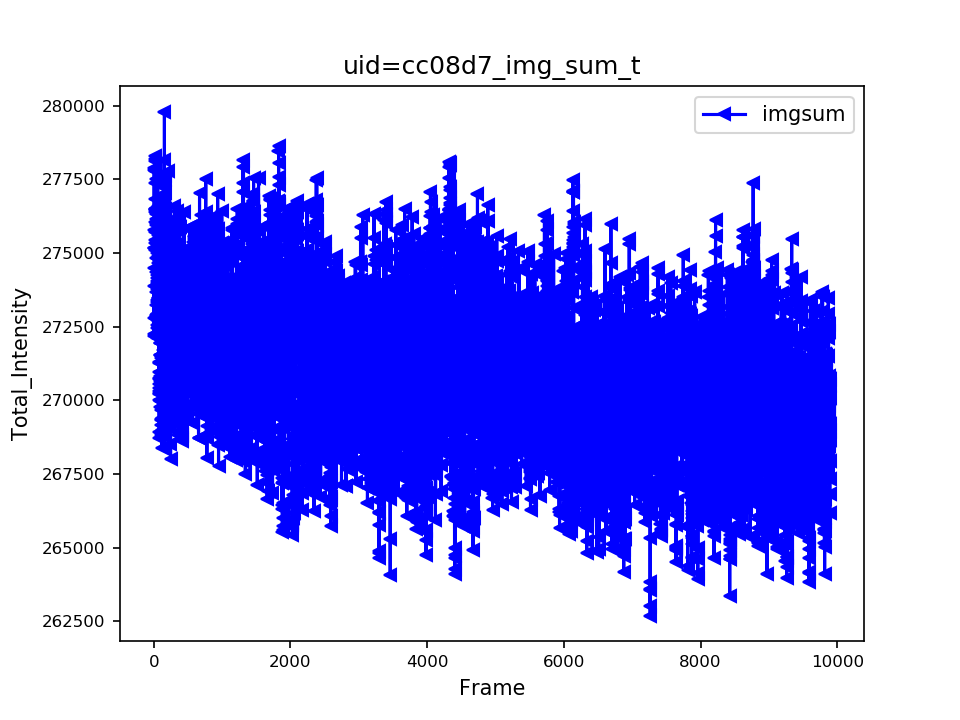

In [65]:
plot1D( y = imgsum_y, title = uidstr + '_img_sum_t', xlabel='Frame', c='b',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

## Get Dynamic Mask (currently designed for 500K)

In [67]:
#%run /home/yuzhang/pyCHX_link/pyCHX/chx_packages.py

  0%|          | 0/2 [00:00<?, ?it/s]

Create dynamic mask for 500K due to 9K data acquistion!!!


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


<IPython.core.display.Javascript object>


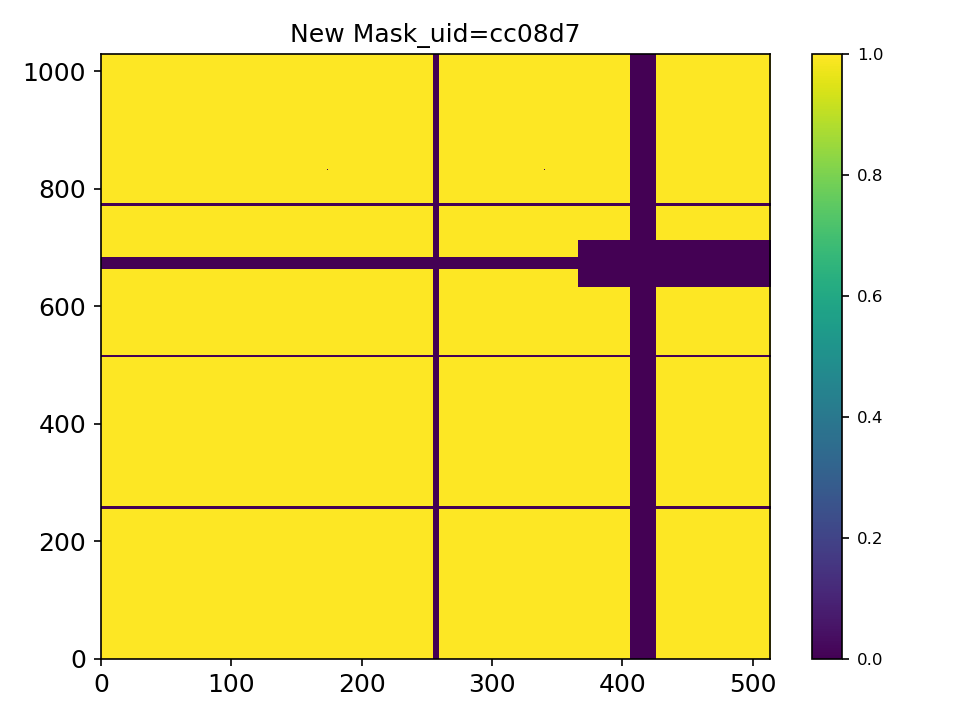

In [68]:
if  md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    pass
elif md['detector'] =='eiger500K_single_image':  
    #if md['cam_acquire_period'] <= 0.00015:  #will check this logic
    if imgs[0].dtype == 'uint16':
        print('Create dynamic mask for 500K due to 9K data acquistion!!!')
        bdp = find_bad_pixels_FD( bad_frame_list, FD, img_shape = avg_img.shape, threshold=20 )    
        mask = mask_copy2.copy()
        mask *=bdp 
        mask_copy = mask.copy()
        show_img(  mask, image_name='New Mask_uid=%s'%uid )

# Static Analysis

## SAXS Scattering Geometry

In [69]:
setup_pargs 

{'uid': 'uid=cc08d7',
 'dpix': 0.07500000356230885,
 'Ldet': 10114.29977417,
 'lambda_': 1.2852099,
 'exposuretime': 0.000114042785,
 'timeperframe': 0.00012,
 'center': [674, 416],
 'path': '/XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/'}

In [70]:
#np.where(hmask.ravel()==0)

<IPython.core.display.Javascript object>


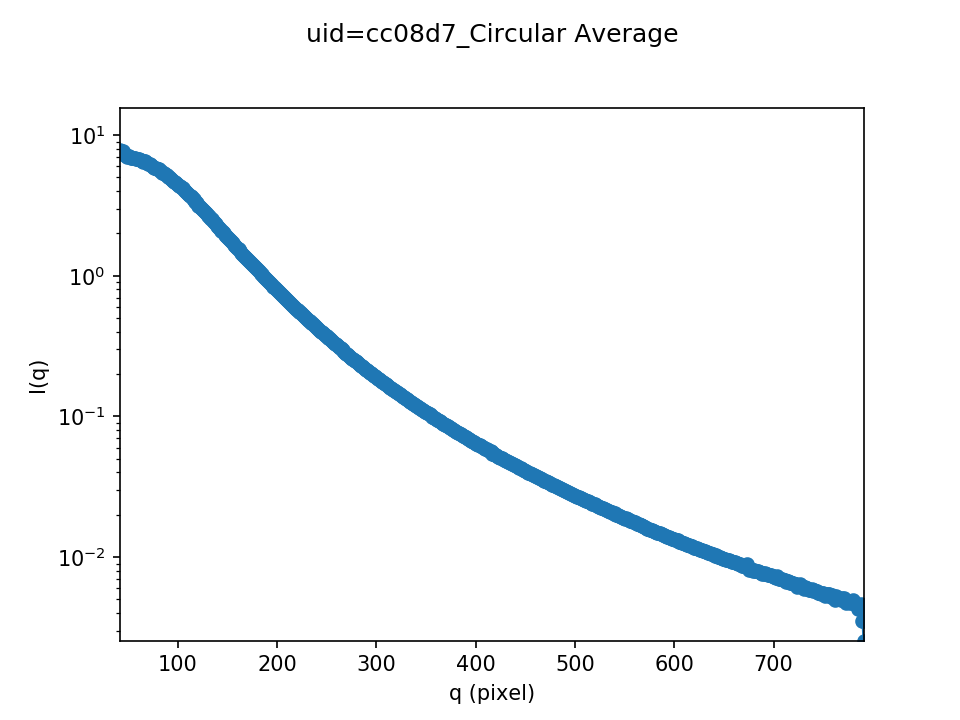

In [71]:
if scat_geometry =='saxs':
    ## Get circular average| * Do plot and save q~iq
    mask = mask_copy.copy()
    hmask = create_hot_pixel_mask( avg_img, threshold = 1e8, center=center, center_radius= 10)
    
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img * Chip_Mask , mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs,  show_pixel=True,
                      xlim=[qp_saxs.min(), qp_saxs.max()*1.0], ylim = [iq_saxs.min(), iq_saxs.max()*2] )
    mask =np.array( mask * hmask, dtype=bool) 

10


<IPython.core.display.Javascript object>


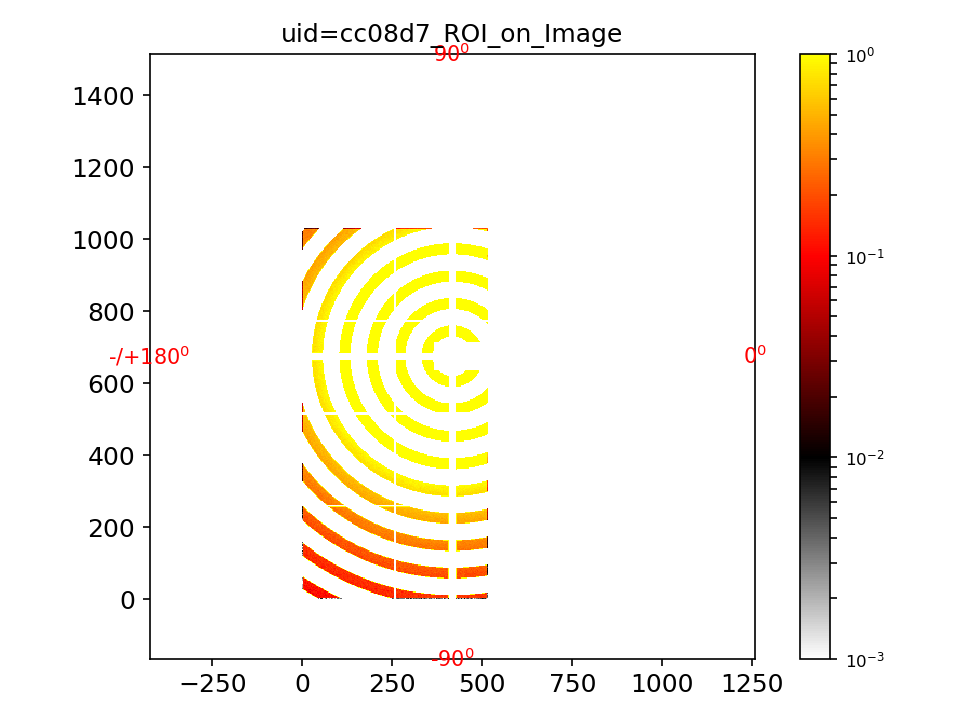

<IPython.core.display.Javascript object>


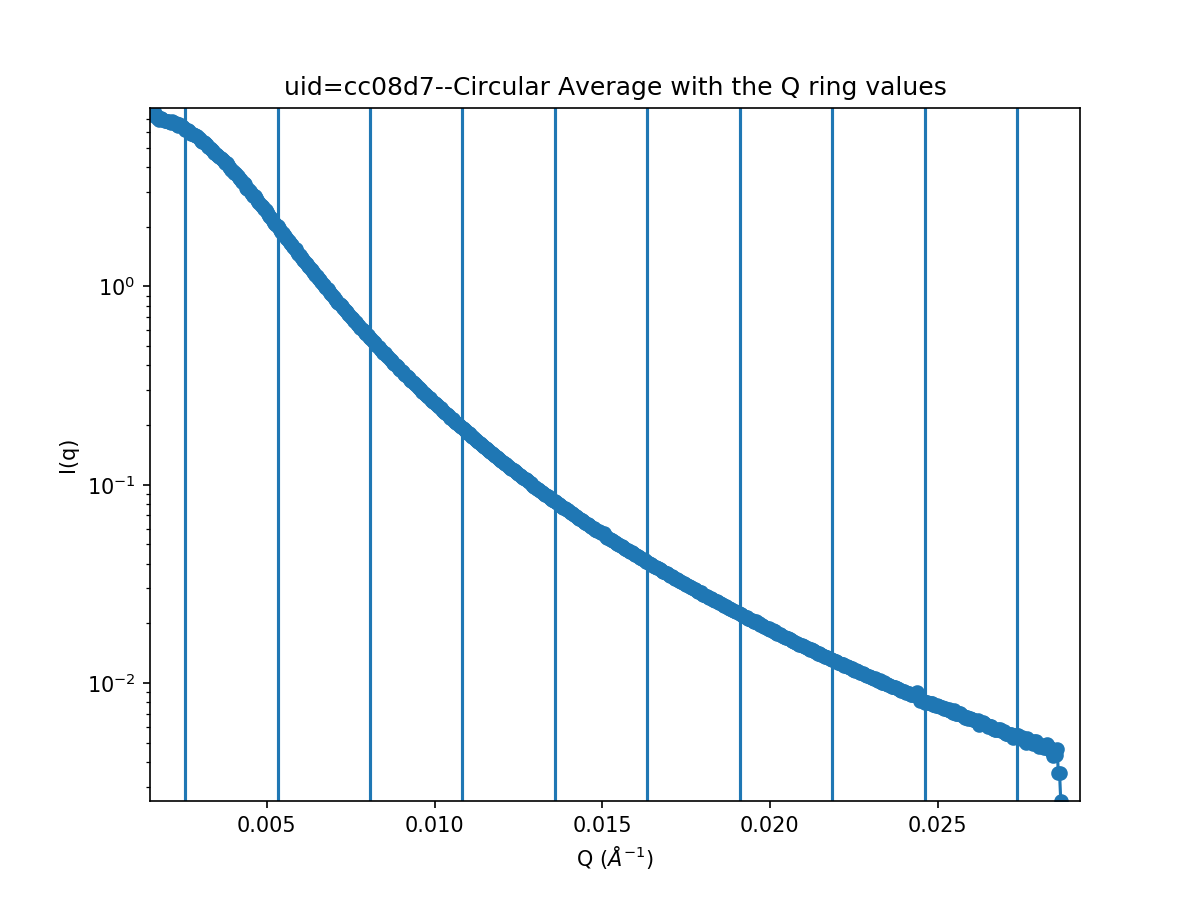

In [73]:
if scat_geometry =='saxs':    
    if run_fit_form:        
        form_res = fit_form_factor( q_saxs,iq_saxs,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])  
        
    qr = np.array( [qval_dict[k][0] for k in sorted( qval_dict.keys())] )
    print(len(qr))
    show_ROI_on_image( avg_img*roi_mask, roi_mask, center, label_on = False, rwidth = 840, alpha=.9,  
                 save=True, path=data_dir, uid=uidstr, vmin= 1e-3,
                 vmax= 1e-1, #np.max(avg_img),
                 aspect=1,
                 show_roi_edge=True,     
                 show_ang_cor = True) 
    plot_qIq_with_ROI( q_saxs, iq_saxs, np.unique(qr), logs=True, uid=uidstr, 
                      xlim=[q_saxs.min(), q_saxs.max()*1.02],#[0.0001,0.08],
                  ylim = [iq_saxs.min(), iq_saxs.max()*1.02],  save=True, path=data_dir)
    
    roi_mask = roi_mask * mask

# Time Depedent I(q) Analysis

<IPython.core.display.Javascript object>


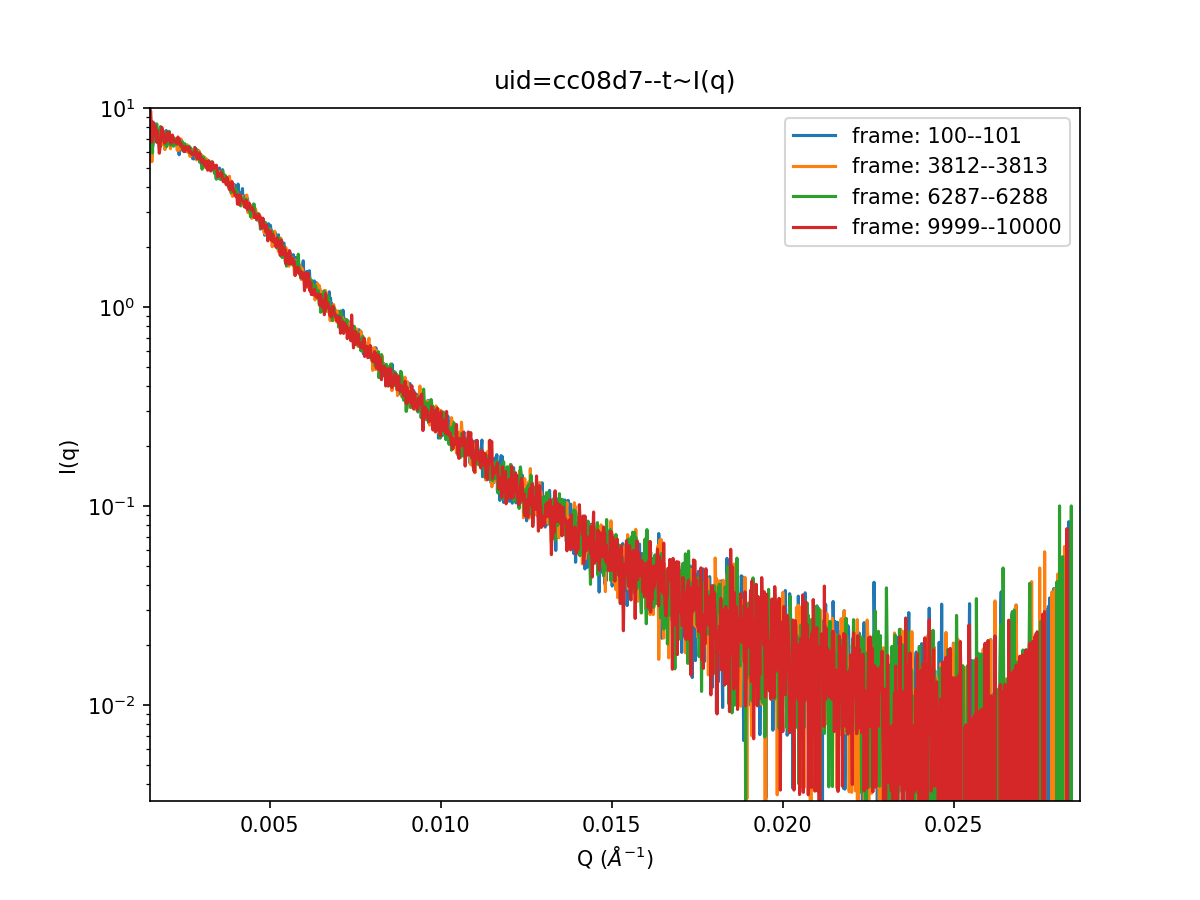

/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


In [74]:
if scat_geometry =='saxs':
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( Nimg, slice_num= 4, slice_width= 1, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    #print( time_edge )    
    qpt, iqst, qt = get_t_iqc( FD, time_edge, mask*Chip_Mask, pargs=setup_pargs, nx=1500, show_progress= False )
    plot_t_iqc( qt, iqst, time_edge, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )

In [81]:
if run_invariant_analysis:
    if scat_geometry =='saxs':
        invariant = get_iq_invariant( qt, iqst )
        time_stamp = time_edge[:,0] * timeperframe

    if scat_geometry =='saxs':
        plot_q2_iq( qt, iqst, time_stamp,pargs=setup_pargs,ylim=[ -0.001, 0.01] , 
                   xlim=[0.007,0.2],legend_size= 6  )

    if scat_geometry =='saxs':
        plot_time_iq_invariant( time_stamp, invariant, pargs=setup_pargs,  )

    if False:
        iq_int = np.zeros( len(iqst) )
        fig, ax = plt.subplots()
        q = qt
        for i in range(iqst.shape[0]):
            yi = iqst[i] * q**2
            iq_int[i] = yi.sum()
            time_labeli = 'time_%s s'%( round(  time_edge[i][0] * timeperframe, 3) )
            plot1D( x = q, y = yi, legend= time_labeli, xlabel='Q (A-1)', ylabel='I(q)*Q^2', title='I(q)*Q^2 ~ time',
                   m=markers[i], c = colors[i], ax=ax, ylim=[ -0.001, 0.01] , xlim=[0.007,0.2],
                  legend_size=4)

        #print( iq_int )

# GiSAXS Scattering Geometry

In [82]:
if scat_geometry =='gi_saxs':    
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks, data= avg_img, uid= uidstr, path = data_dir   )

## Static Analysis for gisaxs

In [83]:
if scat_geometry =='gi_saxs':    
    #roi_masks, qval_dicts = get_gisaxs_roi( Qrs, Qzs, qr_map, qz_map, mask= mask )
    show_qzr_roi( avg_img, roi_masks, inc_x0, ticks[:4], alpha=0.5, save=True, path=data_dir, uid=uidstr )

In [84]:
if  scat_geometry =='gi_saxs':    
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 2, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    print( time_edge )    
    qrt_pds = get_t_qrc( FD, time_edge, Qrs, Qzs, qr_map, qz_map, mask=mask, path=data_dir, uid = uidstr )    
    plot_qrt_pds( qrt_pds, time_edge, qz_index = 0, uid = uidstr, path =  data_dir )

# Make a Profile Plot

In [85]:
if  scat_geometry =='gi_saxs':
    if run_profile_plot:
        xcorners= [ 1100, 1250, 1250, 1100 ]
        ycorners= [ 850, 850, 950, 950 ]   
        waterfall_roi_size = [ xcorners[1] - xcorners[0],  ycorners[2] - ycorners[1]  ]
        waterfall_roi =  create_rectangle_mask(  avg_img, xcorners, ycorners   )
        #show_img( waterfall_roi * avg_img,  aspect=1,vmin=.001, vmax=1, logs=True, )
        wat = cal_waterfallc( FD, waterfall_roi, qindex= 1, bin_waterfall=True,
                              waterfall_roi_size = waterfall_roi_size,save =True, path=data_dir, uid=uidstr)
    

In [86]:
if  scat_geometry =='gi_saxs':
    if run_profile_plot:
        plot_waterfallc( wat, qindex=1, aspect=None, vmin=1, vmax= np.max( wat), uid=uidstr, save =True, 
                        path=data_dir, beg= FD.beg)

## Dynamic Analysis for gi_saxs

In [87]:
if scat_geometry =='gi_saxs':       
    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks[:4], alpha=0.5, save=True, path=data_dir, uid=uidstr )        
    ## Get 1D Curve (Q||-intensity¶)
    qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0= None, mask=mask, setup_pargs=setup_pargs )
    plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=True, save=True, uid=uidstr, path = data_dir)

# GiWAXS Scattering Geometry

In [88]:
if scat_geometry =='gi_waxs':
    #badpixel = np.where( avg_img[:600,:] >=300 )
    #roi_mask[badpixel] = 0
    show_ROI_on_image( avg_img, roi_mask, label_on = True,  alpha=.5,
                 save=True, path=data_dir, uid=uidstr, vmin=0.1, vmax=5)

* Extract the labeled array

In [89]:
qind, pixelist = roi.extract_label_indices(roi_mask)
noqs = len(np.unique(qind))
print(noqs)

10


* Number of pixels in each q box

In [90]:
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([ 8977, 18406, 25254, 32603, 34088, 25527, 18193, 16421, 12520,
        2743])

## Check one ROI intensity

<IPython.core.display.Javascript object>


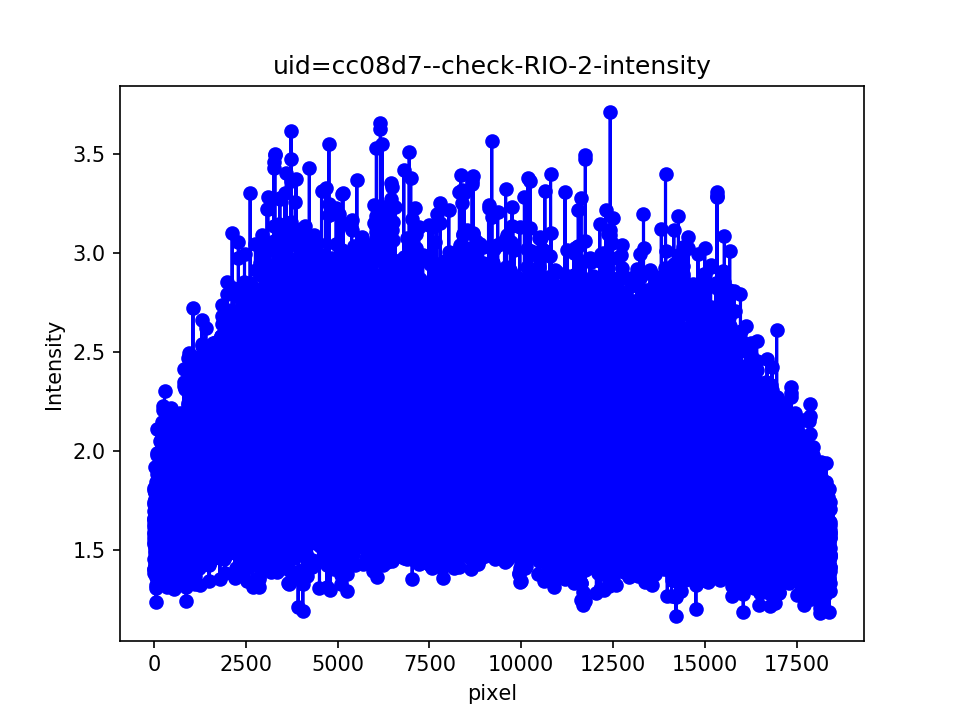

In [91]:
roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= 2, uid =uidstr ) #roi starting from 1

## Do a waterfall analysis

In [93]:
qth_interest = 2 #the second ring. #qth_interest starting from 1
if scat_geometry =='saxs' or scat_geometry =='gi_waxs':
    if run_waterfall:    
        wat = cal_waterfallc( FD, roi_mask, qindex= qth_interest, save =True, path=data_dir, uid=uidstr)
        plot_waterfallc( wat, qth_interest, aspect= None, vmin=1e-1, vmax= wat.max(), uid=uidstr, save =True, 
                        path=data_dir, beg= FD.beg, cmap = cmap_vge )
 

  0%|          | 0/10 [00:00<?, ?it/s]

Starting assign the tasks...
Starting running the tasks...


100%|██████████| 10/10 [00:24<00:00,  2.50s/it]

ROI mean_intensit calculation is DONE!


<IPython.core.display.Javascript object>


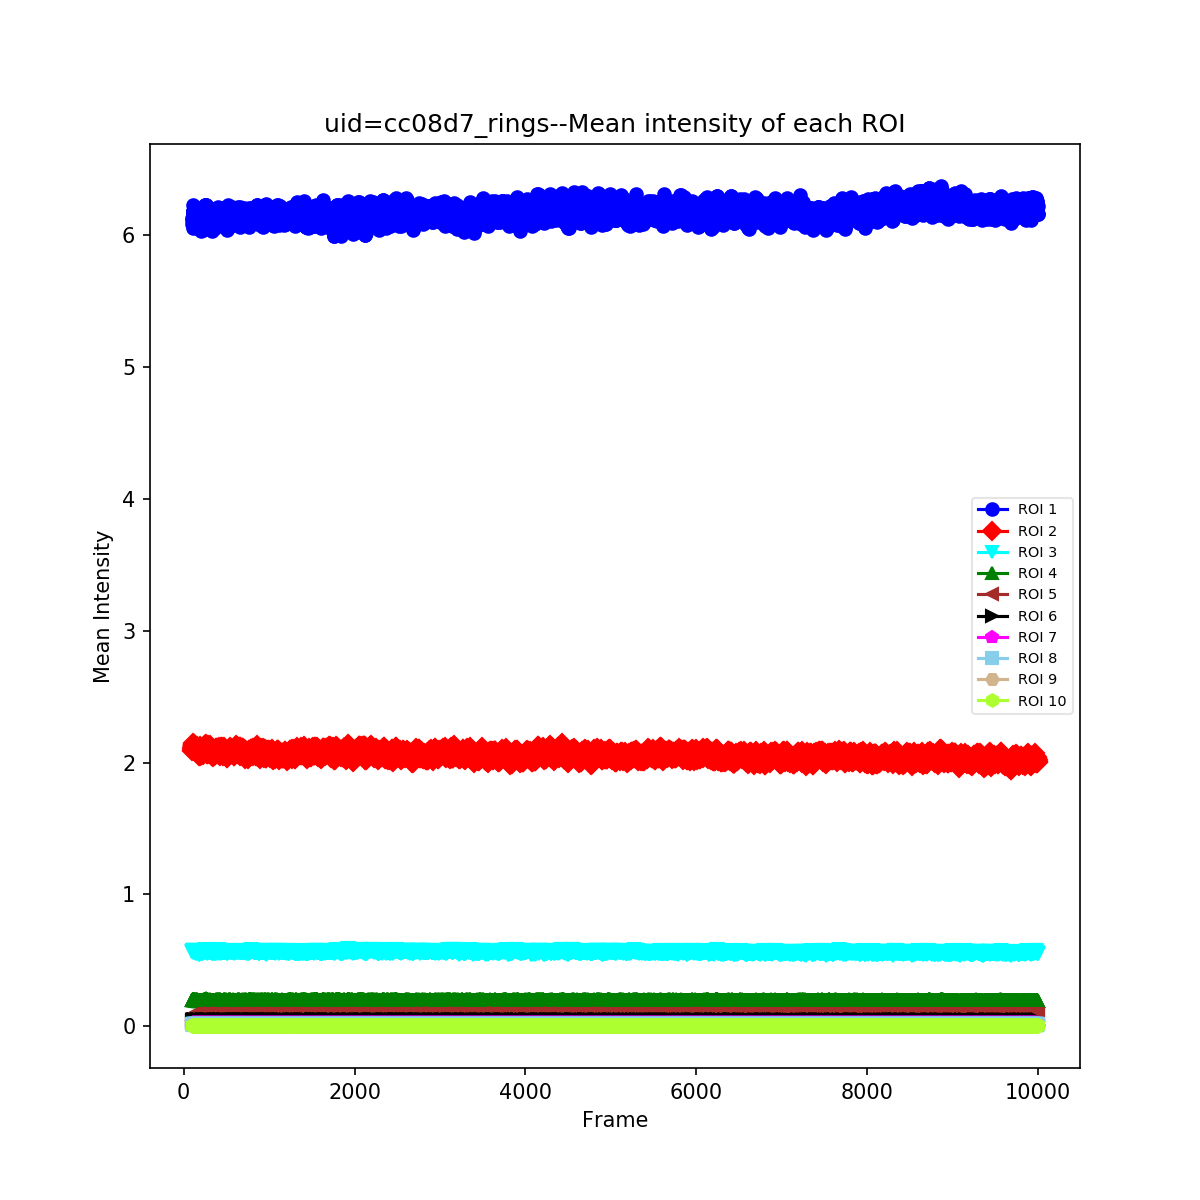

In [94]:
ring_avg = None    
if run_t_ROI_Inten:
    times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, roi_mask, timeperframe = None, multi_cor=True  ) 
    plot_each_ring_mean_intensityc( times_roi, mean_int_sets,  uid = uidstr+'_'+q_mask_name, save=True, path=data_dir )
    roi_avg = np.average( mean_int_sets, axis=0)

## Analysis for mass center of reflective beam center

In [95]:
if run_get_mass_center:
    cx, cy = get_mass_center_one_roi(FD, roi_mask, roi_ind=25)
    

In [96]:
if run_get_mass_center:
    fig,ax=plt.subplots(2)
    plot1D( cx, m='o', c='b',ax=ax[0], legend='mass center-refl_X', 
           ylim=[940, 960], ylabel='posX (pixel)')
    plot1D( cy, m='s', c='r',ax=ax[1], legend='mass center-refl_Y', 
           ylim=[1540, 1544], xlabel='frames',ylabel='posY (pixel)')

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [97]:
define_good_series = False
#define_good_series = True
if define_good_series:
    good_start = 200
    FD = Multifile(filename, beg = good_start, end = 600) #end=1000)
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )

In [99]:
if use_sqnorm:#for transmision SAXS
    norm = get_pixelist_interp_iq( qp_saxs, iq_saxs, roi_mask, center)
    print('Using circular average in the normalization of G2 for SAXS scattering.')
elif use_SG:#for Gi-SAXS or WAXS
    avg_imgf = sgolay2d( avg_img, window_size= 11, order= 5) * mask
    norm=np.ravel(avg_imgf)[pixelist]    
    print('Using smoothed image by SavitzkyGolay filter in the normalization of G2.')    
else:     
    norm= None
    print('Using simple (average) normalization of G2.')      

if use_imgsum_norm:
    imgsum_ = imgsum
    print('Using frame total intensity for intensity normalization in g2 calculation.')      
else:
    imgsum_ = None    
import time

Using circular average in the normalization of G2 for SAXS scattering.
Using frame total intensity for intensity normalization in g2 calculation.


In [100]:
if run_one_time: 
    t0 = time.time()     
    if cal_g2_error:          
        g2,lag_steps,g2_err = cal_g2p(FD,roi_mask,bad_frame_list,good_start, num_buf = 8,
                            num_lev= None,imgsum= imgsum_, norm=norm, cal_error= True )
    else:   
        g2,lag_steps    =     cal_g2p(FD,roi_mask,bad_frame_list,good_start, num_buf = 8,
                            num_lev= None,imgsum= imgsum_, norm=norm, cal_error= False )

    run_time(t0)
    

In this g2 calculation, the buf and lev number are: 8--12--
102 Bad frames involved and will be discarded!
9898 frames will be processed...


  0%|          | 0/10 [00:00<?, ?it/s]

Starting assign the tasks...
Starting running the tasks...


100%|██████████| 10/10 [01:38<00:00,  9.86s/it]

G2 calculation DONE!
Total time: 1.757 min


In [101]:
lag_steps = lag_steps[:g2.shape[0]]
g2.shape[1]


10

In [102]:
if run_one_time:
    
    taus = lag_steps * timeperframe    
    try:
        g2_pds = save_g2_general( g2, taus=taus,qr= np.array( list( qval_dict.values() ) )[:g2.shape[1],0],
                                            qz = np.array( list( qval_dict.values() ) )[:g2.shape[1],1],
                             uid=uid_+'_g2.csv', path= data_dir, return_res=True )
    except:
        g2_pds = save_g2_general( g2, taus=taus,qr= np.array( list( qval_dict.values() ) )[:g2.shape[1],0],                                             
                             uid=uid_+'_'+q_mask_name+'_g2.csv', path= data_dir, return_res=True )        

The correlation function is saved in /XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/ with filename as uid=cc08d7_fra_100_10000_rings_g2.csv


In [103]:
#g2.shape

# Fit g2

In [104]:
if run_one_time:
    g2_fit_result, taus_fit, g2_fit = get_g2_fit_general( g2,  taus, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':False, 'beta': True, 'alpha':True,'relaxation_rate':True,},                                  
            guess_values={'baseline':1.0,'beta': 0.03,'alpha':1.0,'relaxation_rate':0.0005},
            guess_limits = dict( baseline =[.9, 1.3], alpha=[0, 2],
                        beta = [0, 1], relaxation_rate= [1e-7, 1000]) ,) 
    g2_fit_paras = save_g2_fit_para_tocsv(g2_fit_result,  filename= uid_ +'_'+q_mask_name +'_g2_fit_paras.csv', path=data_dir ) 
    

The g2 fitting parameters are saved in /XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/uid=cc08d7_fra_100_10000_rings_g2_fit_paras.csv


In [105]:
scat_geometry_

'saxs'

<IPython.core.display.Javascript object>


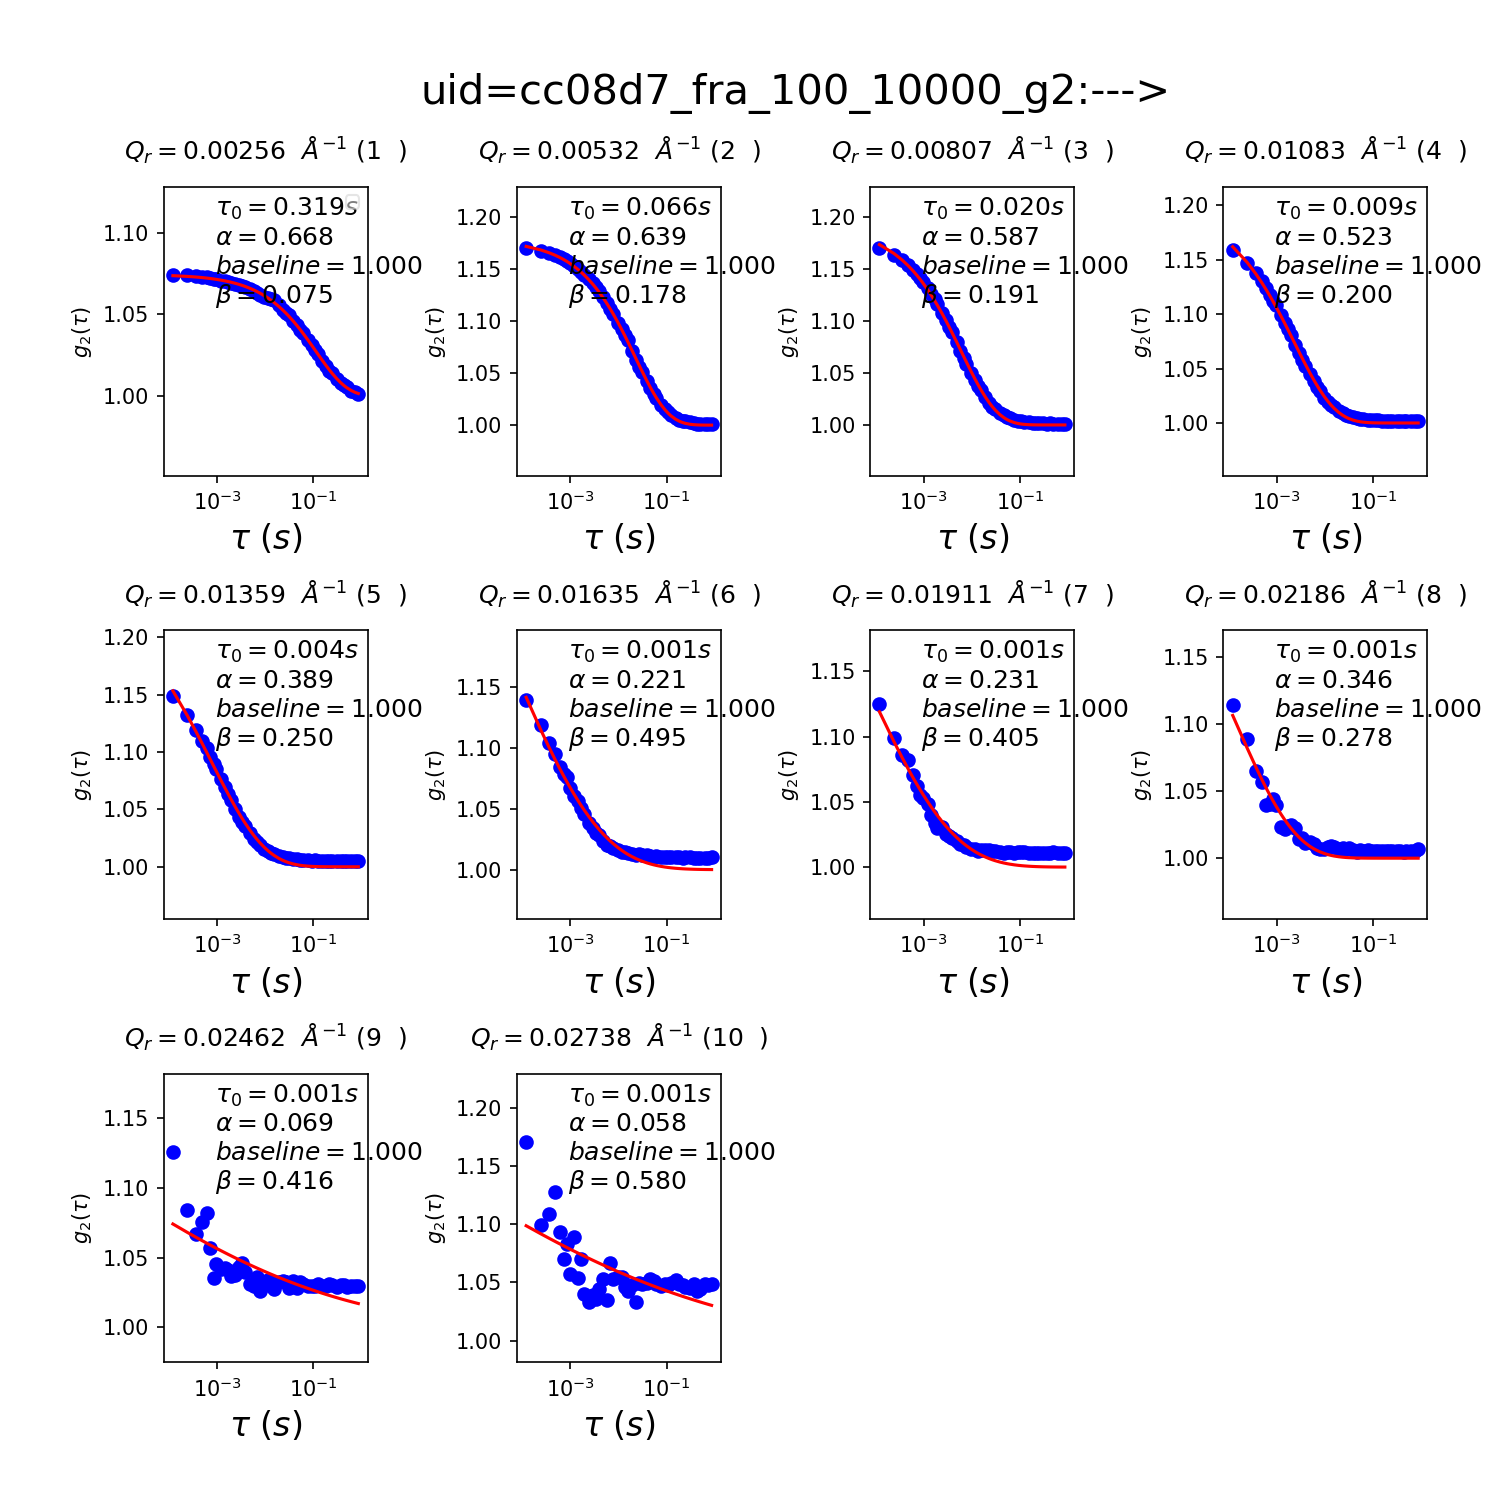

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [106]:
if run_one_time:
    if cal_g2_error:
        g2_fit_err = np.zeros_like(g2_fit)
        plot_g2_general( g2_dict={1:g2, 2:g2_fit}, taus_dict={1:taus, 2:taus_fit},
                    vlim=[0.95, 1.05], g2_err_dict= {1:g2_err, 2: g2_fit_err},
                qval_dict = dict(itertools.islice(qval_dict.items(),g2.shape[1])), fit_res= g2_fit_result,  geometry= scat_geometry_,filename= uid_+'_g2', 
        path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_fit')
    else:    
        plot_g2_general( g2_dict={1:g2, 2:g2_fit}, taus_dict={1:taus, 2:taus_fit}, vlim=[0.95, 1.05],
                qval_dict = dict(itertools.islice(qval_dict.items(),g2.shape[1])), fit_res= g2_fit_result,  geometry= scat_geometry_,filename= uid_+'_g2', 
        path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_fit')
    


The fitted diffusion coefficient D0 is:  2.080e+06   A^2S-1


<IPython.core.display.Javascript object>


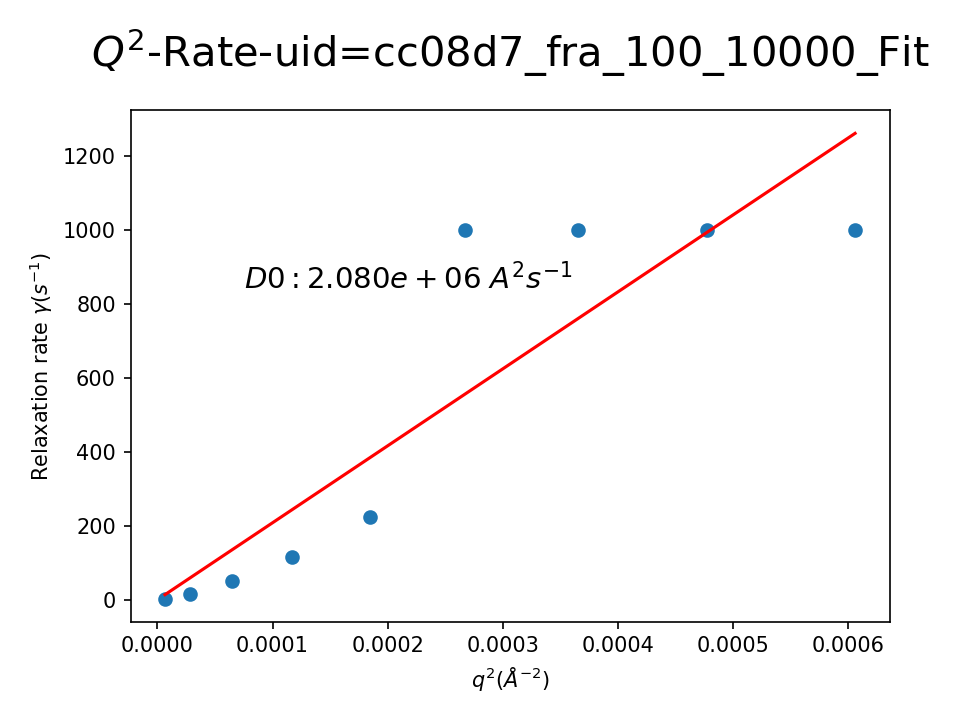

In [107]:
if run_one_time:
    if True:
        fs, fe = 0, 9
        #fs,fe=0, 6
        qval_dict_ = {k:qval_dict[k] for k in list(qval_dict.keys())[fs:fe]  }
        D0, qrate_fit_res = get_q_rate_fit_general(  qval_dict_, g2_fit_paras['relaxation_rate'][fs:fe], 
                                                   geometry=  scat_geometry_ )
        plot_q_rate_fit_general( qval_dict_, g2_fit_paras['relaxation_rate'][fs:fe],  qrate_fit_res, 
                                geometry= scat_geometry_,uid=uid_  , path= data_dir )
    else:
        D0, qrate_fit_res = get_q_rate_fit_general(  qval_dict, g2_fit_paras['relaxation_rate'],
                                    fit_range=[0, 26],   geometry= scat_geometry_ )    
        plot_q_rate_fit_general( qval_dict, g2_fit_paras['relaxation_rate'],  qrate_fit_res,   
                            geometry=  scat_geometry_,uid=uid_  ,
                                show_fit=False, path= data_dir, plot_all_range=False)

In [108]:
#plot1D( x= qr, y=g2_fit_paras['beta'], ls='-', m = 'o', c='b', ylabel=r'$\beta$', xlabel=r'$Q( \AA^{-1} ) $' )


# For two-time

In [109]:
define_good_series = False
#define_good_series = True
if define_good_series:
    good_start = 5
    FD = Multifile(filename, beg = good_start, end = 1000)
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )

In [111]:
data_pixel = None
if run_two_time:    
    data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm= norm ).get_data()

100%|██████████| 9900/9900 [00:32<00:00, 304.53it/s]


In [112]:
import time
t0=time.time()
g12b=None
if run_two_time:     
    g12b = auto_two_Arrayc(  data_pixel,  roi_mask, index = None   )
    if run_dose:
        np.save( data_dir + 'uid=%s_g12b'%uid, g12b)
run_time( t0 )  

100%|██████████| 10/10 [01:54<00:00, 11.46s/it]

Total time: 1.911 min


<IPython.core.display.Javascript object>


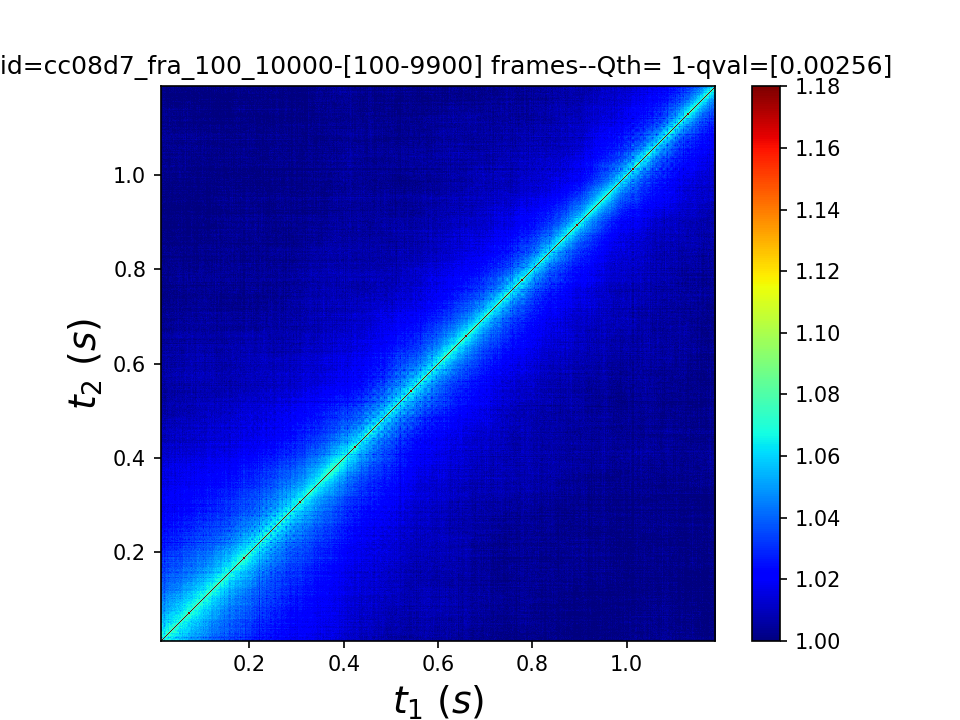

In [114]:
if run_two_time:
    show_C12(g12b, q_ind= 1, qlabel=dict(itertools.islice(qval_dict.items(),g2.shape[1])),N1= FD.beg,logs=False, N2=min( FD.end,10000), vmin= 1.0, vmax=1.18,timeperframe=timeperframe,save=True, path= data_dir, uid = uid_ ,cmap=plt.cm.jet)#cmap=cmap_albula)    

In [116]:
multi_tau_steps = True
if run_two_time:
    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
        
    #max_taus= lag_steps.max()  
    max_taus = Nimg    
    t0=time.time()
    #tausb = np.arange( g2b.shape[0])[:max_taus] *timeperframe
    if multi_tau_steps:
        lag_steps_ = lag_steps[   lag_steps <= g12b.shape[0] ]
        g2b = get_one_time_from_two_time(g12b)[lag_steps_]
        tausb = lag_steps_ *timeperframe
    else:
        tausb = (np.arange( g12b.shape[0]) *timeperframe)[:-200]
        g2b = (get_one_time_from_two_time(g12b))[:-200]
    run_time(t0)
         
    g2b_pds = save_g2_general( g2b, taus=tausb, qr= np.array( list( qval_dict.values() ) )[:g2.shape[1],0],
                              qz=None, uid=uid_+'_'+q_mask_name+'_g2b.csv', path= data_dir, return_res=True )
    

Total time: 7.282 sec
The correlation function is saved in /XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/ with filename as uid=cc08d7_fra_100_10000_rings_g2b.csv


In [117]:
if run_two_time:    
    g2b_fit_result, tausb_fit, g2b_fit = get_g2_fit_general( g2b,  tausb, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':False, 'beta': True, 'alpha':True,'relaxation_rate':True},                                  
            guess_values={'baseline':1.0,'beta': 0.15,'alpha':1.0,'relaxation_rate':1e-3,},
            guess_limits = dict( baseline =[1, 1.8], alpha=[0, 2],
                        beta = [0, 1], relaxation_rate= [1e-8, 5000]) ) 
    g2b_fit_paras = save_g2_fit_para_tocsv(g2b_fit_result,  filename= uid_  +'_'+q_mask_name+'_g2b_fit_paras.csv', path=data_dir )


The g2 fitting parameters are saved in /XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/uid=cc08d7_fra_100_10000_rings_g2b_fit_paras.csv


In [118]:
#plot1D( x = tausb[1:], y =g2b[1:,0], ylim=[0.95, 1.46], xlim = [0.0001, 10], m='', c='r', ls = '-',
#       logx=True, title='one_time_corelation', xlabel = r"$\tau $ $(s)$",    )

<IPython.core.display.Javascript object>


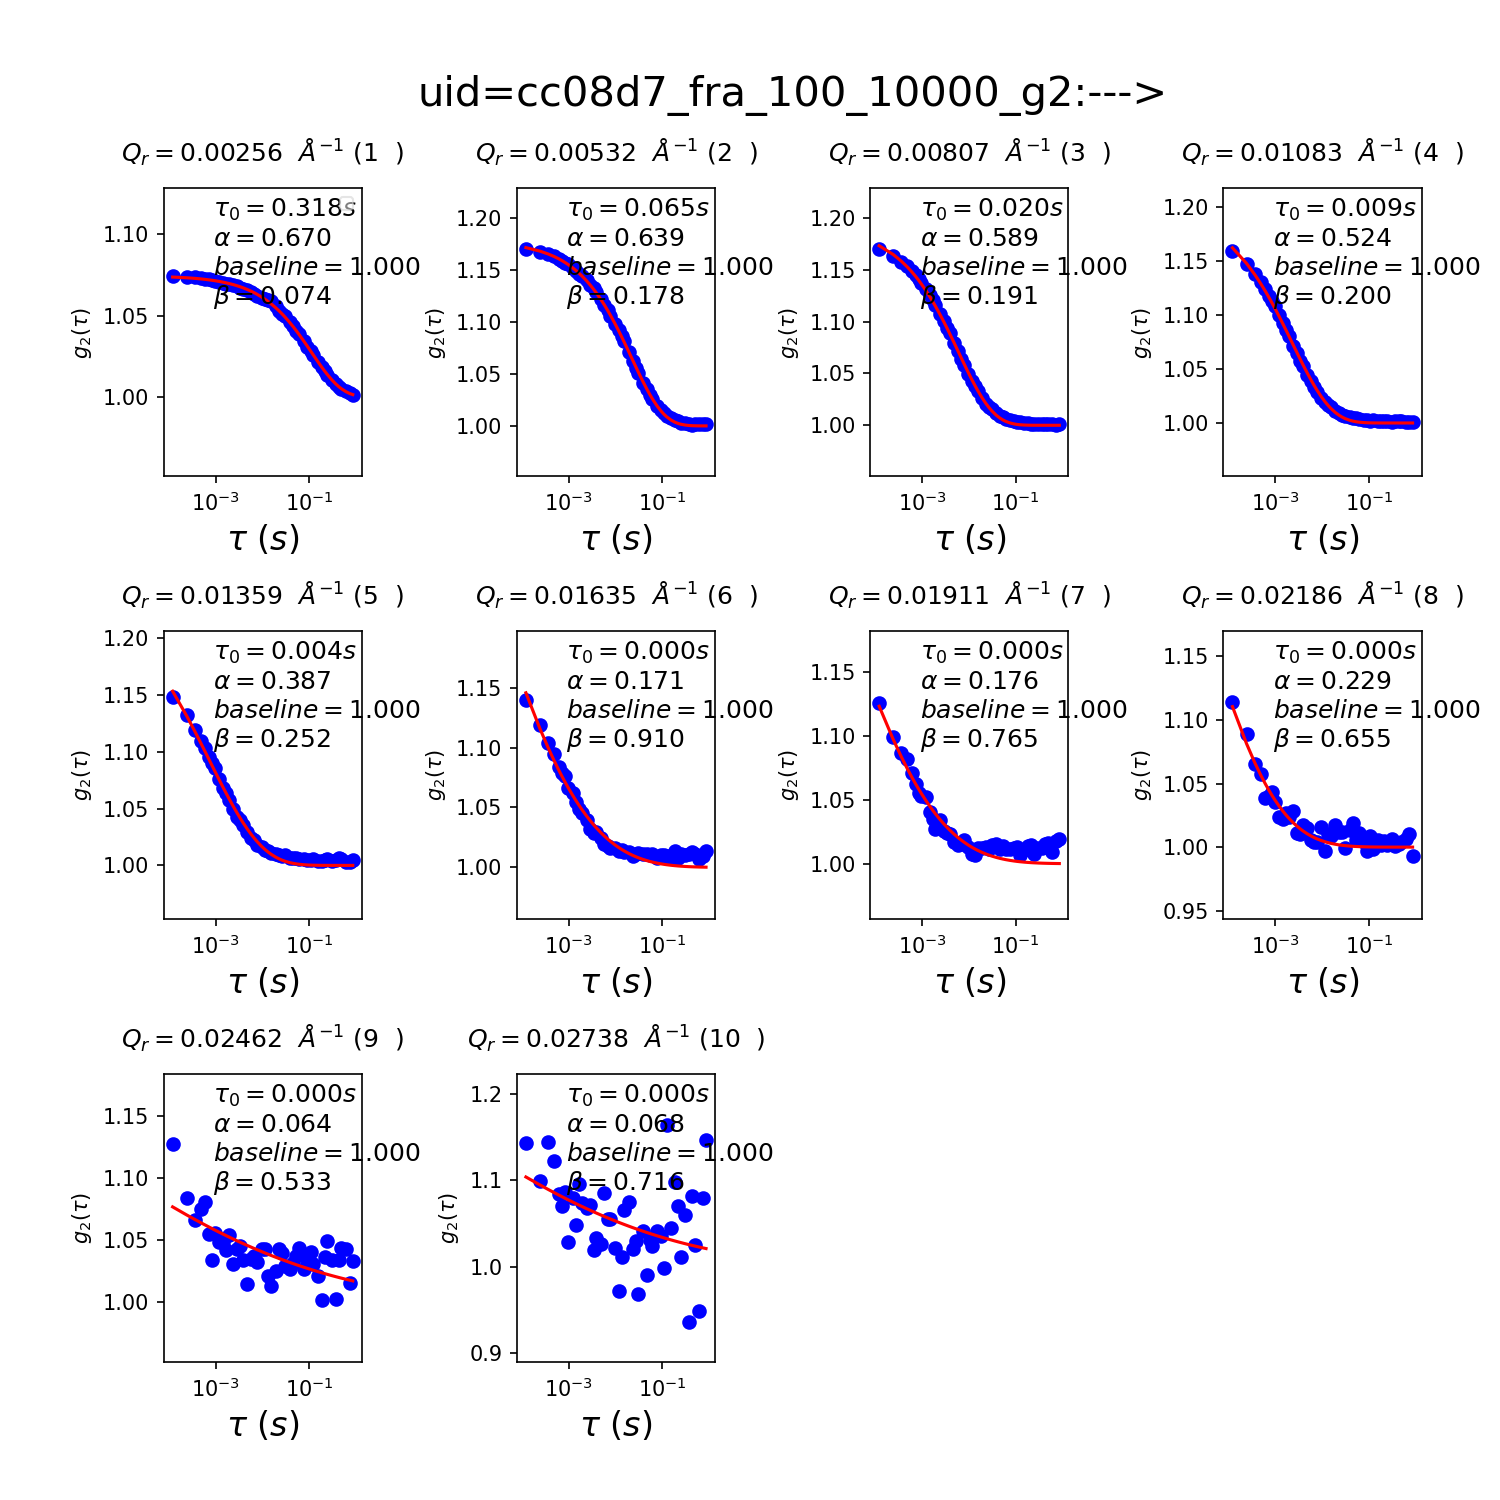

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [119]:
if run_two_time:
    plot_g2_general( g2_dict={1:g2b, 2:g2b_fit}, taus_dict={1:tausb, 2:tausb_fit}, vlim=[0.95, 1.05],
                qval_dict=dict(itertools.islice(qval_dict.items(),g2.shape[1])), fit_res= g2b_fit_result,  geometry=scat_geometry_,filename=uid_+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_b_fit')

In [120]:
if run_two_time:
    D0b, qrate_fit_resb = get_q_rate_fit_general(  dict(itertools.islice(qval_dict.items(),g2.shape[1])), g2b_fit_paras['relaxation_rate'],
                                        fit_range=[0, 10],  geometry= scat_geometry_ )

The fitted diffusion coefficient D0 is:  8.753e+06   A^2S-1


In [121]:
#qval_dict, g2b_fit_paras['relaxation_rate']

The fitted diffusion coefficient D0 is:  1.012e+07   A^2S-1


<IPython.core.display.Javascript object>


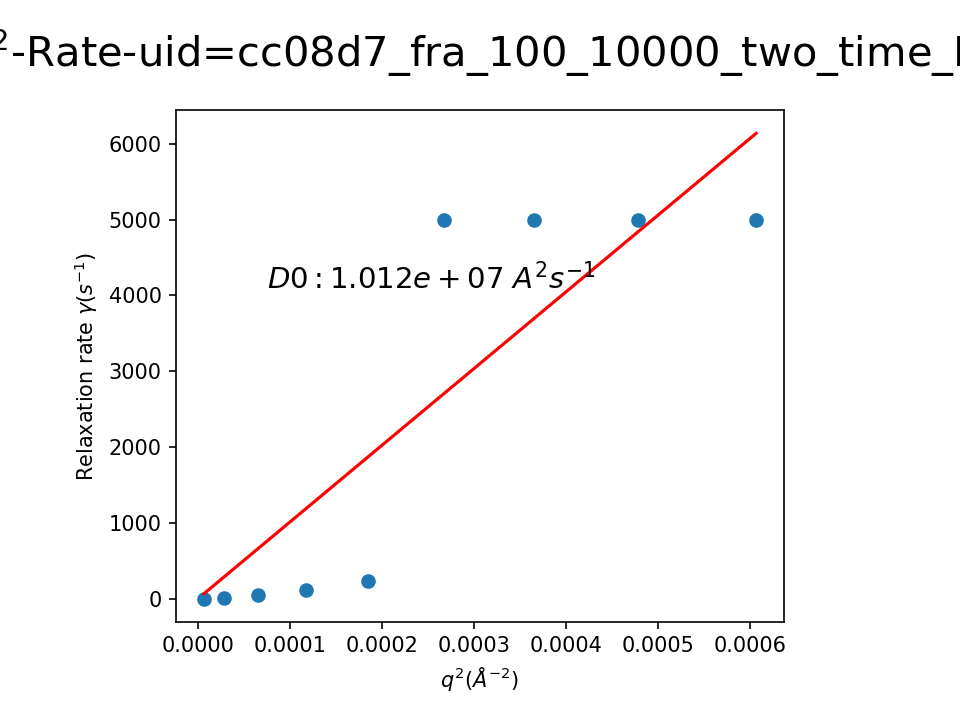

In [122]:
if run_two_time:    
    if True:
        fs, fe = 0,9
        #fs, fe = 0,12
        qval_dict_ = {k:qval_dict[k] for k in list(qval_dict.keys())[fs:fe]  }
        D0b, qrate_fit_resb = get_q_rate_fit_general(  qval_dict_, g2b_fit_paras['relaxation_rate'][fs:fe], geometry= scat_geometry_ )
        plot_q_rate_fit_general( qval_dict_, g2b_fit_paras['relaxation_rate'][fs:fe],  qrate_fit_resb, 
                            geometry= scat_geometry_,uid=uid_ +'_two_time' , path= data_dir )
    else:
    
        D0b, qrate_fit_resb = get_q_rate_fit_general(  qval_dict, g2b_fit_paras['relaxation_rate'],
                                        fit_range=[0, 10],  geometry= scat_geometry_ )
        plot_q_rate_fit_general( qval_dict, g2b_fit_paras['relaxation_rate'],  qrate_fit_resb,   
                            geometry= scat_geometry_,uid=uid_ +'_two_time', show_fit=False,path= data_dir, plot_all_range= True )

<IPython.core.display.Javascript object>


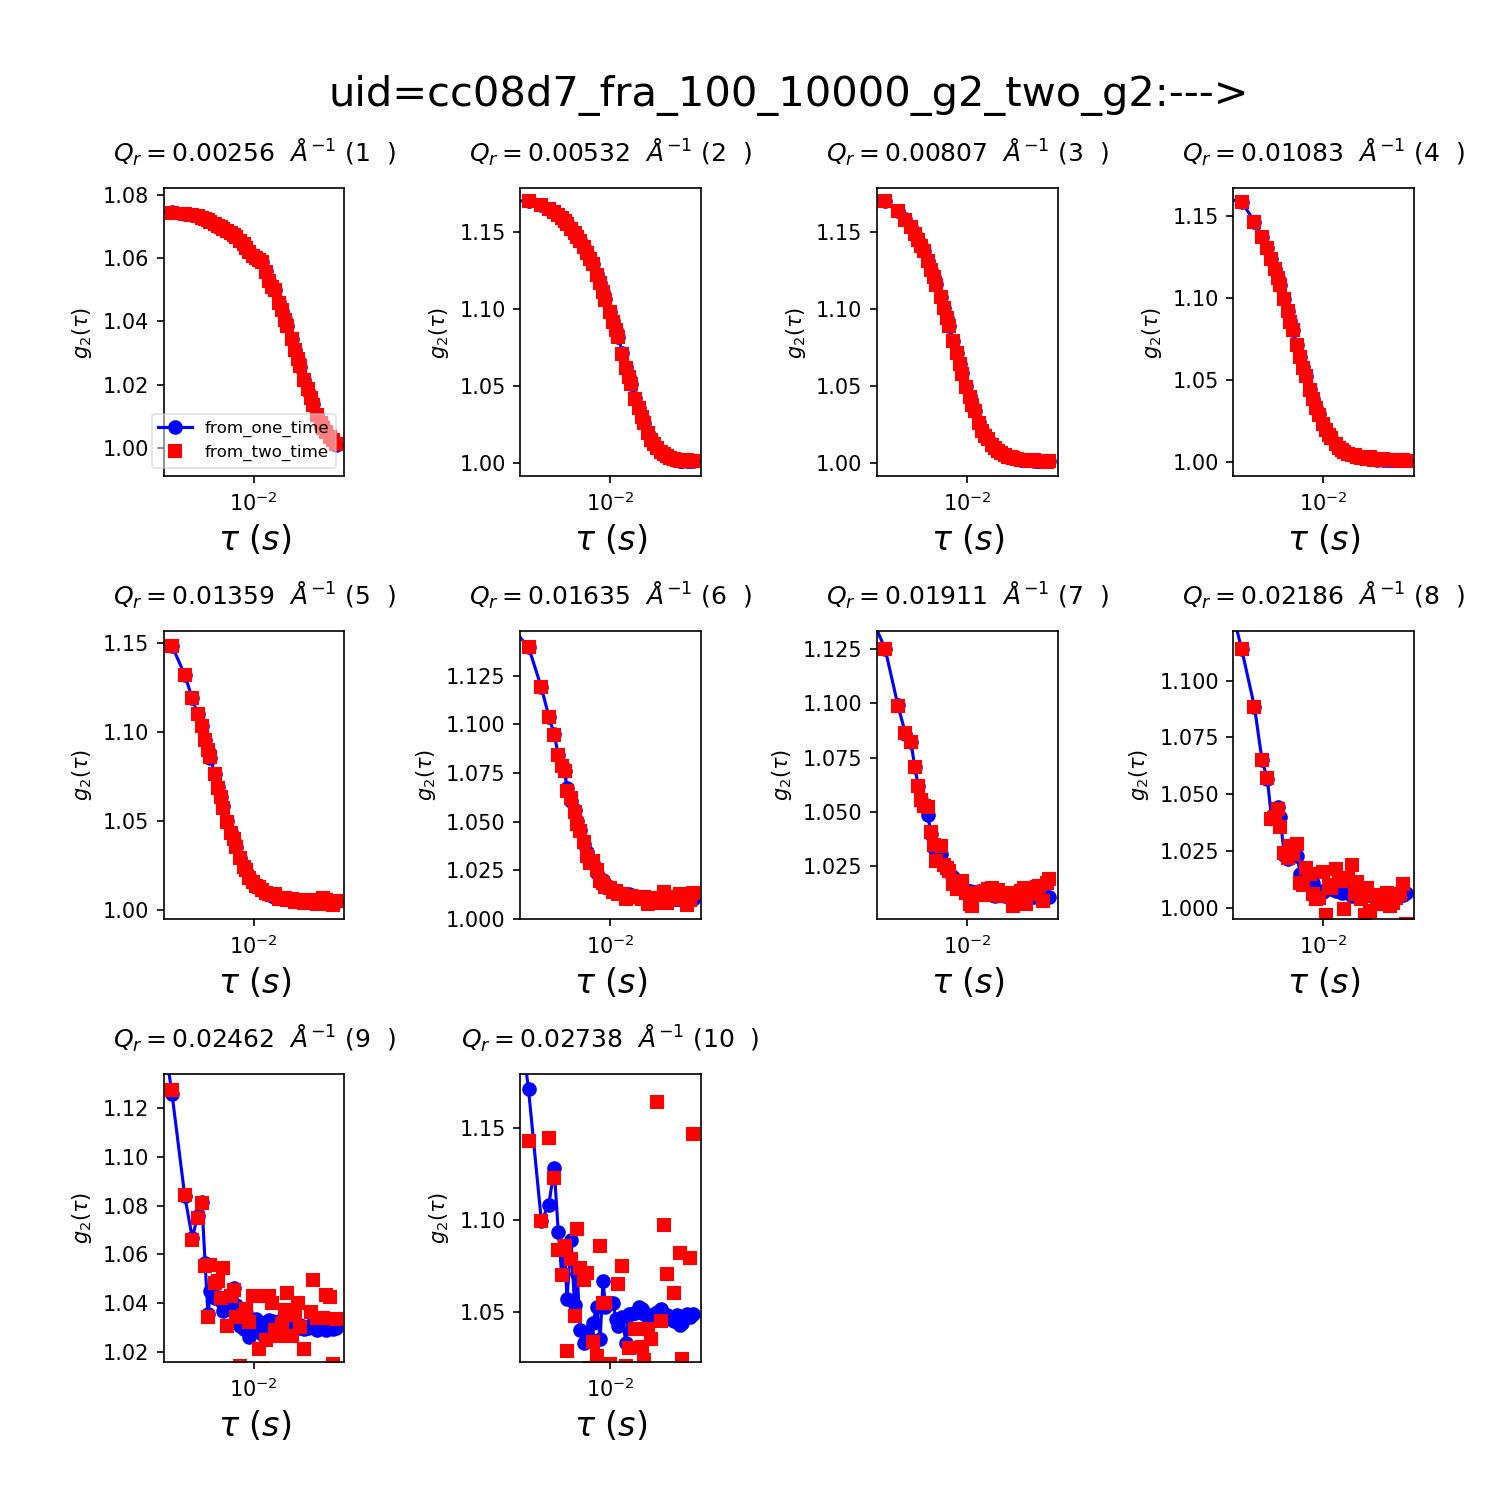

In [123]:
if run_two_time and run_one_time:
    plot_g2_general( g2_dict={1:g2, 2:g2b}, taus_dict={1:taus, 2:tausb},vlim=[0.99, 1.007],
                qval_dict=dict(itertools.islice(qval_dict.items(),g2.shape[1])), g2_labels=['from_one_time', 'from_two_time'],
            geometry=scat_geometry_,filename=uid_+'_g2_two_g2', path= data_dir, ylabel='g2', )

# Run Dose dependent analysis

In [144]:
#run_dose = True

In [145]:
if run_dose:
    get_two_time_mulit_uids( [uid], roi_mask,  norm= norm,  bin_frame_number=1, 
                        path= data_dir0, force_generate=False, compress_path =  cmp_path + '/' )

UID: cc08d7 is in processing...
filepath : /nsls2/xf11id1/data/2018/07/25/272622f3-bd01-4496-b39c
got images_per_file
More than one device. This would have unintented consequences.Currently, only use the first device.


  0%|          | 0/10 [00:00<?, ?it/s]/nsls2/xf11id1/analysis/Analysis_Pipelines/Develop/pyCHX/pyCHX/chx_correlationc.py:1397: RuntimeWarning: divide by zero encountered in true_divide
  g12b[:,:, i  ] = np.dot(   data_pixel_qi, data_pixel_qi.T)  /sum1  / sum2  / nopr[qi -1]
/nsls2/xf11id1/analysis/Analysis_Pipelines/Develop/pyCHX/pyCHX/chx_correlationc.py:1397: RuntimeWarning: invalid value encountered in true_divide
  g12b[:,:, i  ] = np.dot(   data_pixel_qi, data_pixel_qi.T)  /sum1  / sum2  / nopr[qi -1]
100%|██████████| 10/10 [01:57<00:00, 11.73s/it]


The two time correlation function for uid=cc08d7 is saved as /XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/uid=cc08d7_g12b.


In [146]:
try:
    print( md['transmission'] )
except:
    md['transmission'] =1

1.0


In [147]:
exposuretime

0.000114042785

In [148]:
if run_dose:
    N = len(imgs)
    print(N)
    exposure_dose = md['transmission'] * exposuretime* np.int_([     N/16, N/8, N/4 ,N/2, 3*N/4, N*0.99 ])
    #exposure_dose = md['transmission'] * exposuretime* np.int_([   N/8, N/4 ,N/2, 3*N/4, N*0.99 ])
    
    print( exposure_dose )

10000
[0.07127674 0.14255348 0.28510696 0.57021392 0.85532089 1.12902357]


In [149]:
if run_dose:
    taus_uids, g2_uids = get_series_one_time_mulit_uids( [ uid ],  qval_dict, good_start=good_start,  
                    path= data_dir0, exposure_dose = exposure_dose,  num_bufs =8, save_g2= False,
                                                   dead_time = 0, trans = [ md['transmission'] ] )

UID: cc08d7 is in processing...
More than one device. This would have unintented consequences.Currently, only use the first device.
uid: cc08d7--> fra_num_by_dose: [ 625 1250 2500 5000 7500 9900]


<IPython.core.display.Javascript object>


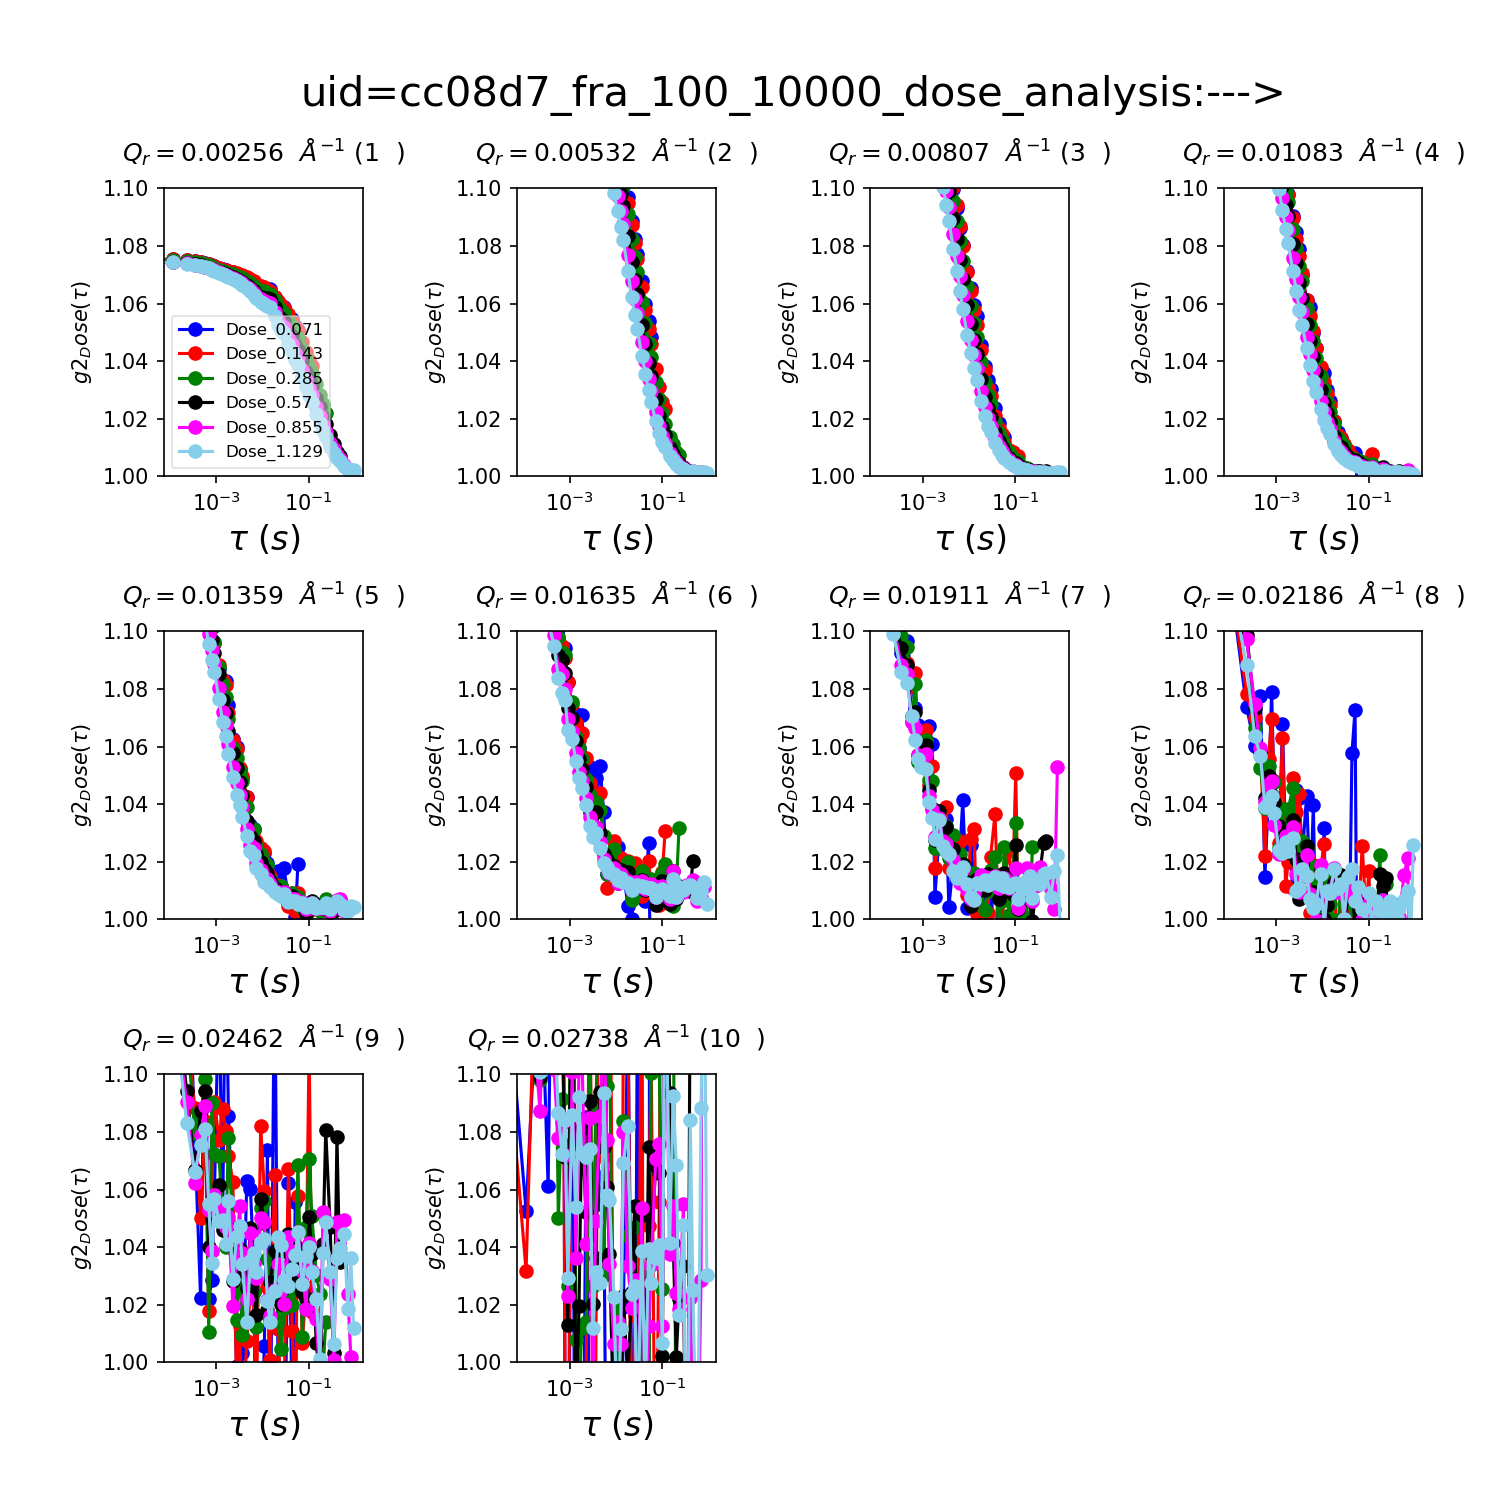

In [150]:
if run_dose:    
    plot_dose_g2( taus_uids, g2_uids, ylim=[1.0, 1.1], vshift= 0.00,
                 qval_dict = qval_dict, fit_res= None,  geometry= scat_geometry_,
                 filename= '%s_dose_analysis'%uid_, 
                path= data_dir, function= None,  ylabel='g2_Dose', g2_labels= None, append_name=  '' )

<IPython.core.display.Javascript object>


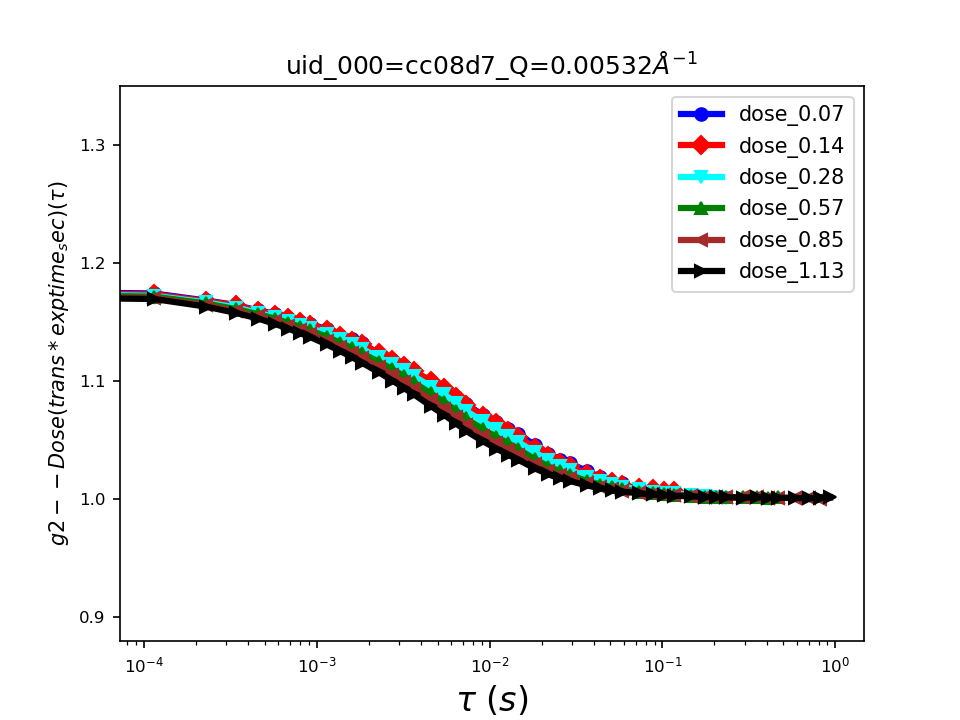

In [151]:
if run_dose:
    qth_interest = 2
    plot_dose_g2( taus_uids, g2_uids, qth_interest= qth_interest, ylim=[0.88, 1.35], vshift= 0.00,
                 qval_dict = qval_dict, fit_res= None,  geometry= scat_geometry_,
                 filename= '%s_dose_analysis'%uidstr, 
                path= data_dir, function= None,  ylabel='g2_Dose', g2_labels= None, append_name=  '' )

# Four Time Correlation

In [167]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:int(max_taus)]
    run_time(t0)

In [168]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe        
    g4_pds = save_g2_general( g4, taus=taus4, qr=np.array( list( qval_dict.values() ) )[:,0],
                             qz=None, uid=uid_ +'_g4.csv', path= data_dir, return_res=True )

In [169]:
if run_four_time:
    plot_g2_general( g2_dict={1:g4}, taus_dict={1:taus4},vlim=[0.95, 1.05], qval_dict=qval_dict, fit_res= None, 
                geometry=scat_geometry_,filename=uid_+'_g4',path= data_dir,   ylabel='g4')

# Speckle Visiblity

In [170]:
#run_xsvs =True

In [171]:
if run_xsvs:    
    max_cts = get_max_countc(FD, roi_mask )    
    #max_cts = 15 #for eiger 500 K
    qind, pixelist = roi.extract_label_indices(   roi_mask  )
    noqs = len( np.unique(qind) )
    nopr = np.bincount(qind, minlength=(noqs+1))[1:]
    #time_steps = np.array( utils.geometric_series(2,   len(imgs)   ) )
    time_steps = [0,1]  #only run the first two levels
    num_times = len(time_steps)    
    times_xsvs = exposuretime + (2**(  np.arange( len(time_steps) ) ) -1 ) * timeperframe   
    print( 'The max counts are: %s'%max_cts )


### Do historam 

In [172]:
if run_xsvs:
    if roi_avg is  None:
        times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, roi_mask, timeperframe = None,  ) 
        roi_avg = np.average( mean_int_sets, axis=0)
    
    t0=time.time()
    spec_bins, spec_his, spec_std, spec_sum  =  xsvsp( FD, np.int_(roi_mask), norm=None,
                max_cts=int(max_cts+2),  bad_images=bad_frame_list, only_two_levels=True )    
    spec_kmean =  np.array(  [roi_avg * 2**j for j in  range( spec_his.shape[0] )] )
    run_time(t0)
    spec_pds =  save_bin_his_std( spec_bins, spec_his, spec_std, filename=uid_+'_spec_res.csv', path=data_dir ) 

### Do historam fit by negtive binominal function with maximum likehood method

In [173]:
if run_xsvs:    
    ML_val, KL_val,K_ = get_xsvs_fit(  spec_his, spec_sum, spec_kmean, 
                        spec_std, max_bins=2, fit_range=[1,60], varyK= False  )
    #print( 'The observed average photon counts are: %s'%np.round(K_mean,4))
    #print( 'The fitted average photon counts are: %s'%np.round(K_,4)) 
    print( 'The difference sum of average photon counts between fit and data are: %s'%np.round( 
            abs(np.sum( spec_kmean[0,:] - K_ )),4))
    print( '#'*30)
    qth=   0 
    print( 'The fitted M for Qth= %s are: %s'%(qth, ML_val[qth]) )
    print( K_[qth])
    print( '#'*30)

## Plot fit results

In [174]:
if run_xsvs:   
    qr = [qval_dict[k][0] for k in list(qval_dict.keys()) ]
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std=spec_std,
                  xlim = [0,10], vlim =[.9, 1.1],
        uid=uid_, qth= qth_interest, logy= True, times= times_xsvs, q_ring_center=qr, path=data_dir)
    
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std = spec_std,
                  xlim = [0,15], vlim =[.9, 1.1],
        uid=uid_, qth= None, logy= True, times= times_xsvs, q_ring_center=qr, path=data_dir )

### Get contrast

In [175]:
if run_xsvs:
    contrast_factorL = get_contrast( ML_val)
    spec_km_pds = save_KM(  spec_kmean, KL_val, ML_val, qs=qr, level_time=times_xsvs, uid=uid_, path = data_dir )
    #spec_km_pds

### Plot contrast with g2 results

In [176]:
if run_xsvs:    
    plot_g2_contrast( contrast_factorL, g2b, times_xsvs, tausb, qr, 
                     vlim=[0.8,1.2], qth = qth_interest, uid=uid_,path = data_dir, legend_size=14)

    plot_g2_contrast( contrast_factorL, g2b, times_xsvs, tausb, qr, 
                     vlim=[0.8,1.2], qth = None, uid=uid_,path = data_dir, legend_size=4)

In [177]:
#from chxanalys.chx_libs import cmap_vge, cmap_albula, Javascript

# Export Results to a HDF5 File

In [178]:
md['mask_file']= mask_path + mask_name
md['roi_mask_file']= fp
md['mask'] = mask
#md['NOTEBOOK_FULL_PATH'] =  data_dir + get_current_pipeline_fullpath(NFP).split('/')[-1]
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list
md['avg_img'] = avg_img
md['roi_mask'] = roi_mask
md['setup_pargs'] = setup_pargs
if scat_geometry == 'gi_saxs':        
    md['Qr'] = Qr
    md['Qz'] = Qz
    md['qval_dict'] = qval_dict
    md['beam_center_x'] =  inc_x0
    md['beam_center_y']=   inc_y0
    md['beam_refl_center_x'] = refl_x0
    md['beam_refl_center_y'] = refl_y0


elif scat_geometry == 'gi_waxs':
    md['beam_center_x'] =  center[1]
    md['beam_center_y']=  center[0]
else:
    md['qr']= qr
    #md['qr_edge'] = qr_edge
    md['qval_dict'] = qval_dict
    md['beam_center_x'] =  center[1]
    md['beam_center_y']=  center[0]            

md['beg'] = FD.beg
md['end'] = FD.end
md['t_print0'] = t_print0
md['qth_interest'] = qth_interest
md['metadata_file'] = data_dir + 'uid=%s_md.pkl'%uid

psave_obj(  md, data_dir + 'uid=%s_md.pkl'%uid ) #save the setup parameters
save_dict_csv( md,  data_dir + 'uid=%s_md.csv'%uid, 'w')

Exdt = {} 
if scat_geometry == 'gi_saxs':  
    for k,v in zip( ['md', 'roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list', 'qr_1d_pds'], 
                [md,    roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list, qr_1d_pds] ):
        Exdt[ k ] = v
elif scat_geometry == 'saxs': 
    for k,v in zip( ['md', 'q_saxs', 'iq_saxs','iqst','qt','roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list'], 
                [md, q_saxs, iq_saxs, iqst, qt,roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list] ):
        Exdt[ k ] = v
elif scat_geometry == 'gi_waxs': 
    for k,v in zip( ['md', 'roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list'], 
                [md,       roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list] ):
        Exdt[ k ] = v
        
if run_waterfall:Exdt['wat'] =  wat
if run_t_ROI_Inten:Exdt['times_roi'] = times_roi;Exdt['mean_int_sets']=mean_int_sets
if run_one_time:
    if run_invariant_analysis:
        for k,v in zip( ['taus','g2','g2_fit_paras', 'time_stamp','invariant'], [taus,g2,g2_fit_paras,time_stamp,invariant] ):Exdt[ k ] = v
    else:
        for k,v in zip( ['taus','g2','g2_fit_paras'  ], [taus,g2,g2_fit_paras ] ):Exdt[ k ] = v
            
if run_two_time:
    for k,v in zip( ['tausb','g2b','g2b_fit_paras', 'g12b'], [tausb,g2b,g2b_fit_paras,g12b] ):Exdt[ k ] = v
    #for k,v in zip( ['tausb','g2b','g2b_fit_paras', ], [tausb,g2b,g2b_fit_paras] ):Exdt[ k ] = v    
if run_dose:
    for k,v in zip( [ 'taus_uids', 'g2_uids' ], [taus_uids, g2_uids] ):Exdt[ k ] = v
if run_four_time:
    for k,v in zip( ['taus4','g4'], [taus4,g4] ):Exdt[ k ] = v
if run_xsvs:
    for k,v in zip( ['spec_kmean','spec_pds','times_xsvs','spec_km_pds','contrast_factorL'], 
                   [ spec_kmean,spec_pds,times_xsvs,spec_km_pds,contrast_factorL] ):Exdt[ k ] = v 

In [179]:
#%run chxanalys_link/chxanalys/Create_Report.py

In [180]:
export_xpcs_results_to_h5( 'uid=%s_%s_Res.h5'%(md['uid'],q_mask_name), data_dir, export_dict = Exdt )
#extract_dict = extract_xpcs_results_from_h5( filename = 'uid=%s_Res.h5'%md['uid'], import_dir = data_dir )

The xpcs analysis results are exported to /XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/ with filename as uid=cc08d718-0031-4057-99b0-283f716d6490_rings_Res.h5


In [181]:
#g2npy_filename =  data_dir  + '/' + 'uid=%s_g12b.npy'%uid
#print(g2npy_filename)
#if os.path.exists( g2npy_filename):
#    print('Will delete this file=%s.'%g2npy_filename)
#    os.remove( g2npy_filename  )


In [182]:
#extract_dict = extract_xpcs_results_from_h5( filename = 'uid=%s_Res.h5'%md['uid'], import_dir = data_dir )

In [183]:
#extract_dict = extract_xpcs_results_from_h5( filename = 'uid=%s_Res.h5'%md['uid'], import_dir = data_dir )

# Creat PDF Report

In [185]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

pdf_filename = "XPCS_Analysis_Report2_for_uid=%s%s%s.pdf"%(uid,pdf_version,q_mask_name)
if run_xsvs:
    pdf_filename = "XPCS_XSVS_Analysis_Report_for_uid=%s%s%s.pdf"%(uid,pdf_version,q_mask_name)

In [186]:
#%run /home/yuzhang/chxanalys_link/chxanalys/Create_Report.py

In [187]:
data_dir

'/XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/'

In [188]:
make_pdf_report( data_dir, uid, pdf_out_dir, pdf_filename, username, 
                    run_fit_form,run_one_time, run_two_time, run_four_time, run_xsvs, run_dose,
                report_type= scat_geometry, report_invariant= run_invariant_analysis,
               md = md )

uid=cc08d7_fra_100_10000_g2_fit.png /XF11ID/analysis/2018_2/yuzhang/Results/cc08d718-0031-4057-99b0-283f716d6490/
300.0

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2018_2/yuzhang/Results/XPCS_Analysis_Report2_for_uid=cc08d7_08-01-2018rings.pdf
****************************************


## Attach the PDF report to Olog 

In [ ]:
#%run  /home/yuzhang/chxanalys_link/chxanalys/chx_olog.py

In [189]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    update_olog_uid_with_file( uid[:6], text='Add XPCS Analysis PDF Report', 
                              filename=pdf_out_dir + pdf_filename, append_name='_r3' )

The url=https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog was successfully updated with Add XPCS Analysis PDF Report and with the attachments


# The End!

# 

In [190]:
uid


'cc08d7'

# Save the current pipeline in Results folder

In [191]:
#save_current_pipeline( NFP, data_dir)

In [192]:
#get_current_pipeline_fullpath(NFP)